In [1]:
# This is used to increase the notebook's width to fill the screen, allowing for better plot visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import cv2
import time
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from utils import plot
from utils import split

C:\Users\leoar\AppData\Local\Temp\ipykernel_20736\2810647869.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# The Stony Brook University COVID-19 Positive Cases (Stony Brook) Dataset

This collection of cases was acquired at Stony Brook University from patients who tested positive for COVID-19. The collection includes images from different modalities and organ sites (chest radiographs, chest CTs, brain MRIs, etc.). Radiology imaging data is extremely important in COVID-19 from both a diagnostic and a monitoring perspective, given the crucial nature of COVID-19 pulmonary disease and its rapid phenotypic changes. The datasets are available for building AI systems for diagnostic and prognostic modeling. 

This collection also includes associated clinical data for each patient. The clinical data consists of diagnoses, procedures, lab tests, covid19 specific data values (e.g., intubation status, symptoms at admission) and a set of derived data elements, which were used in analyses of this data. The clinical data is stored as a set of csv files which comply with OMOP Common Data Model data elements. 

The images on the right show automated identification of regions of prognostic importance on baseline chest radiographs. The regions of highest prognostic importance (as determined by the AI algorithm) are observed primarily in lower lung regions, consistent with clinical findings on the corresponding CXRs.

## [Source](https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=89096912)

# Path to Dataset

In [2]:
# Relative path to dataset
data_dir = os.path.join( "..", "..", "..", "..", "Datasets", "COVID19", "Tomografia", "COVIDx CT-3A" )
assert os.path.exists( data_dir ), "Unable to find the relative path to COVIDx CT-3A, please check data_dir..."

#
dataset_name = "Stony Brook"

## Samples Dataframe

In [3]:
# Path to metadata csv
csv_path = os.path.join( data_dir, "combined_metadata.csv" )

# Reads metadata as dataframe, "age" column is treated as str since "N/A" can't be int
samples_df = pd.read_csv(csv_path, sep = ";", na_filter = False, dtype={"age": str})

samples_df.head()

,filename,patient_id,source,class,country,sex,age,partition,slice_selection,x_min,y_min,x_max,y_max,verified_finding,view,modality
0,NCP_96_1328_0032.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,9,94,512,405,Yes,Axial,CT
1,NCP_96_1328_0035.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,106,512,405,Yes,Axial,CT
2,NCP_96_1328_0036.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,105,512,406,Yes,Axial,CT
3,NCP_96_1328_0037.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,104,512,406,Yes,Axial,CT
4,NCP_96_1328_0038.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,103,512,406,Yes,Axial,CT


## Patients Dataframe

In [4]:
# Creates a new dataframe with metadata sorted by patient
patient_df = plot.convert_df_sample2patient( samples_df )

patient_df.head()

,patient_id,source,class,country,sex,age,partition,slice_selection,verified_finding,view,modality,sample_count
0,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,Yes,Axial,CT,121
1,NCP_270,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,124
2,NCP_322,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,40
3,NCP_1276,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,32
4,NCP_2683,CNCB,COVID-19,China,N/A,N/A,train,Expert,Yes,Axial,CT,9


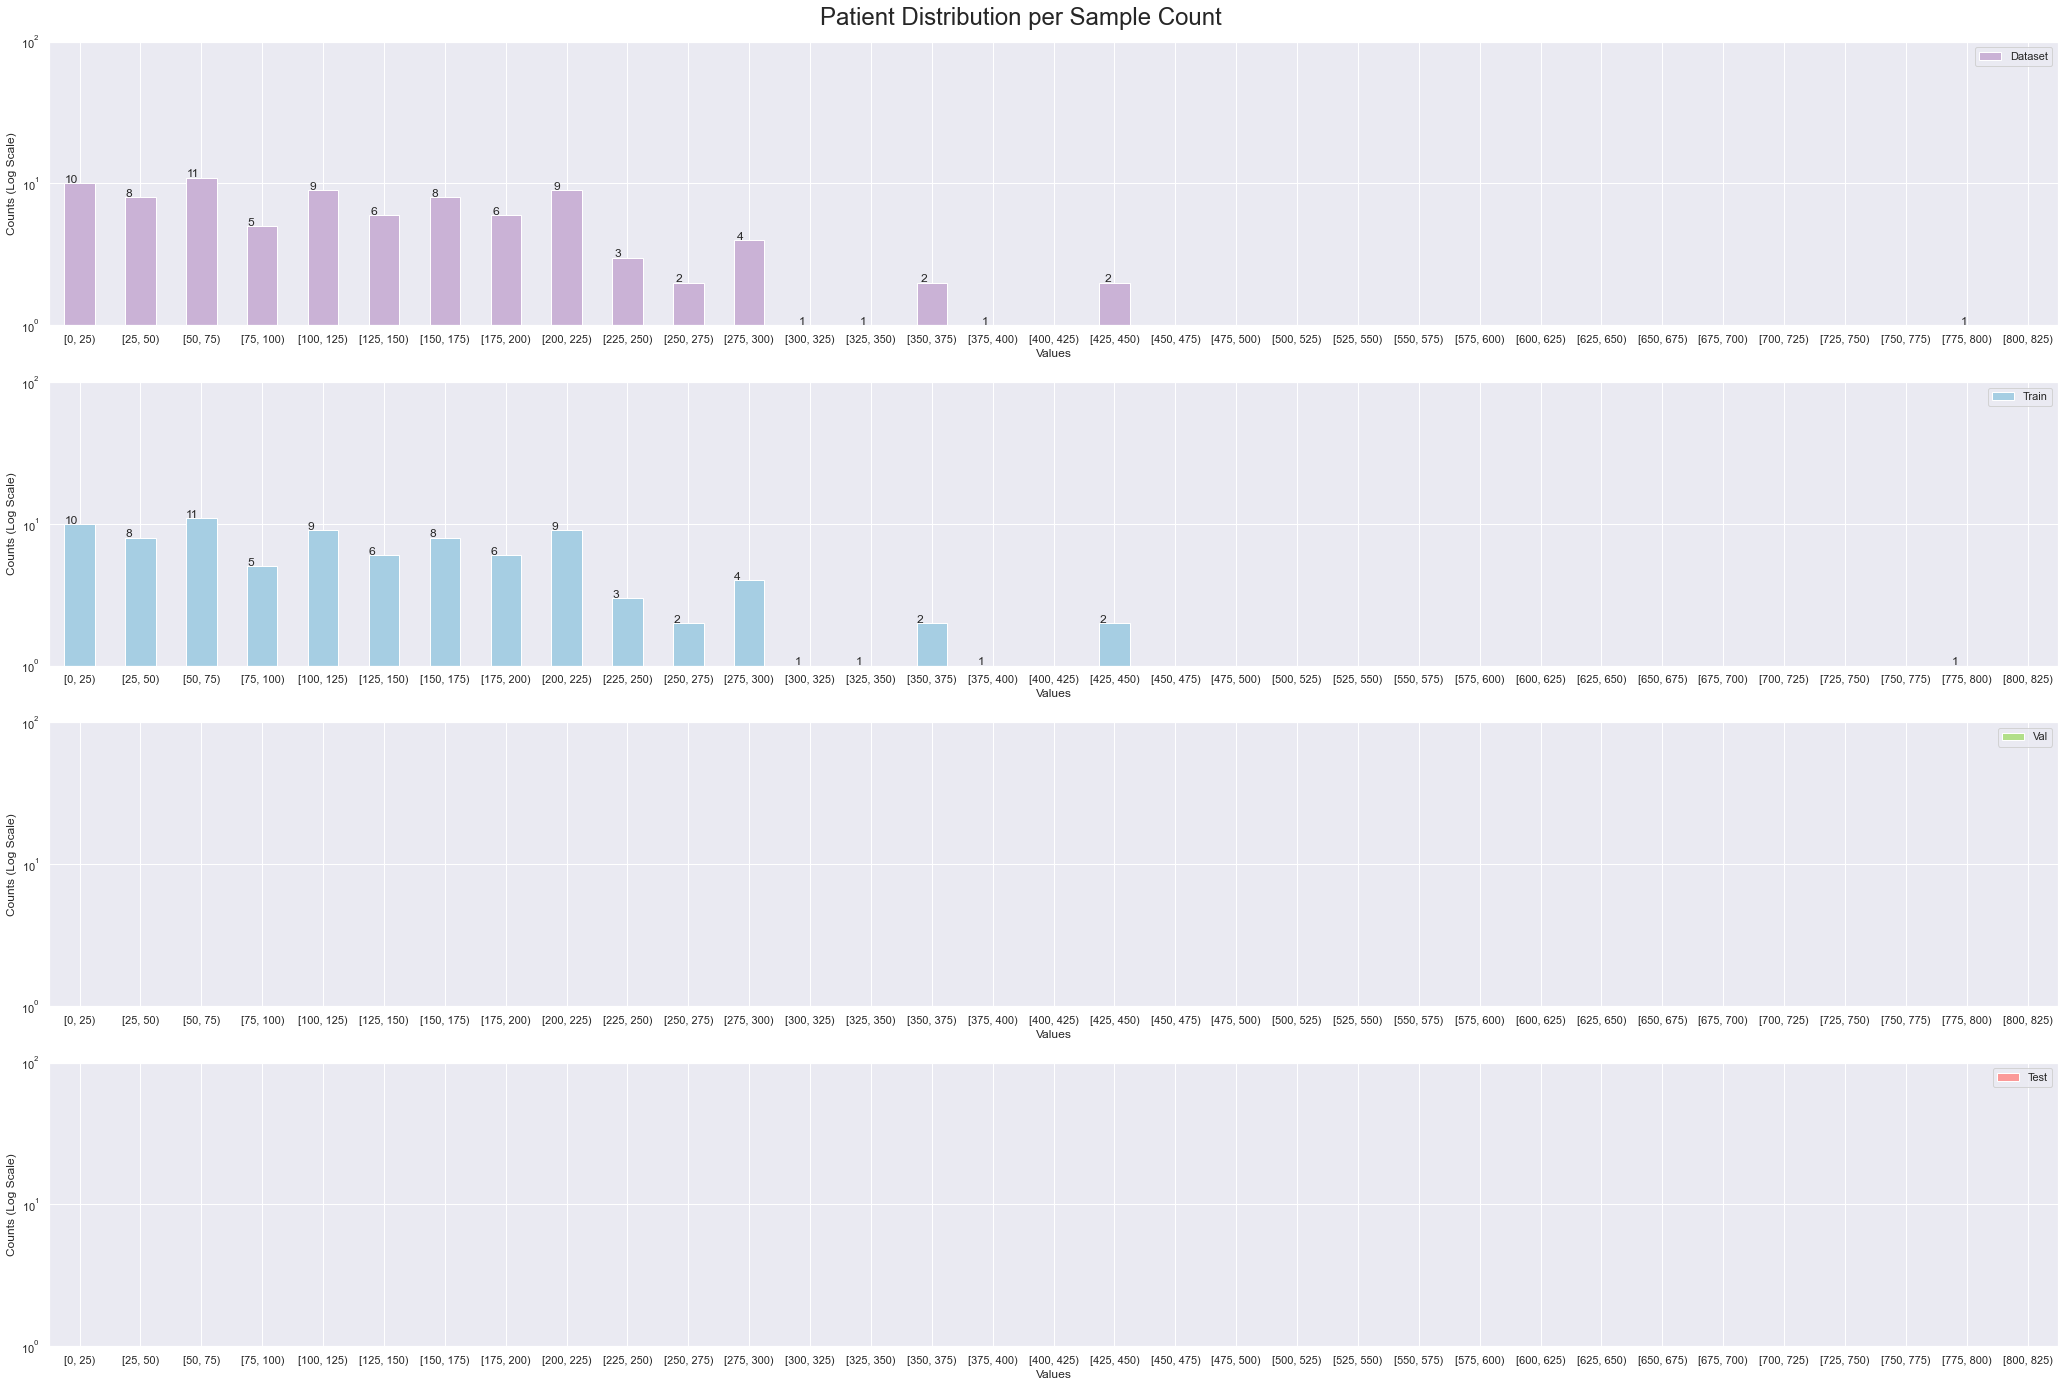

In [5]:
figure = plt.figure( figsize = (36, 24) )
plot.column_per_partition_as_histogram( patient_df, "sample_count", dataset_name, figure, title_complement = "Patient")

In [6]:
counts_df = plot.column_bins_per_partition_as_df( patient_df, "sample_count", dataset_name )
counts_df.head(len(counts_df))

,Dataset,Train,Val,Test
Values,,,,
"[0, 25)",10,10,0,0
"[25, 50)",8,8,0,0
"[50, 75)",11,11,0,0
"[75, 100)",5,5,0,0
"[100, 125)",9,9,0,0
"[125, 150)",6,6,0,0
"[150, 175)",8,8,0,0
"[175, 200)",6,6,0,0
"[200, 225)",9,9,0,0


# Plots

## Class

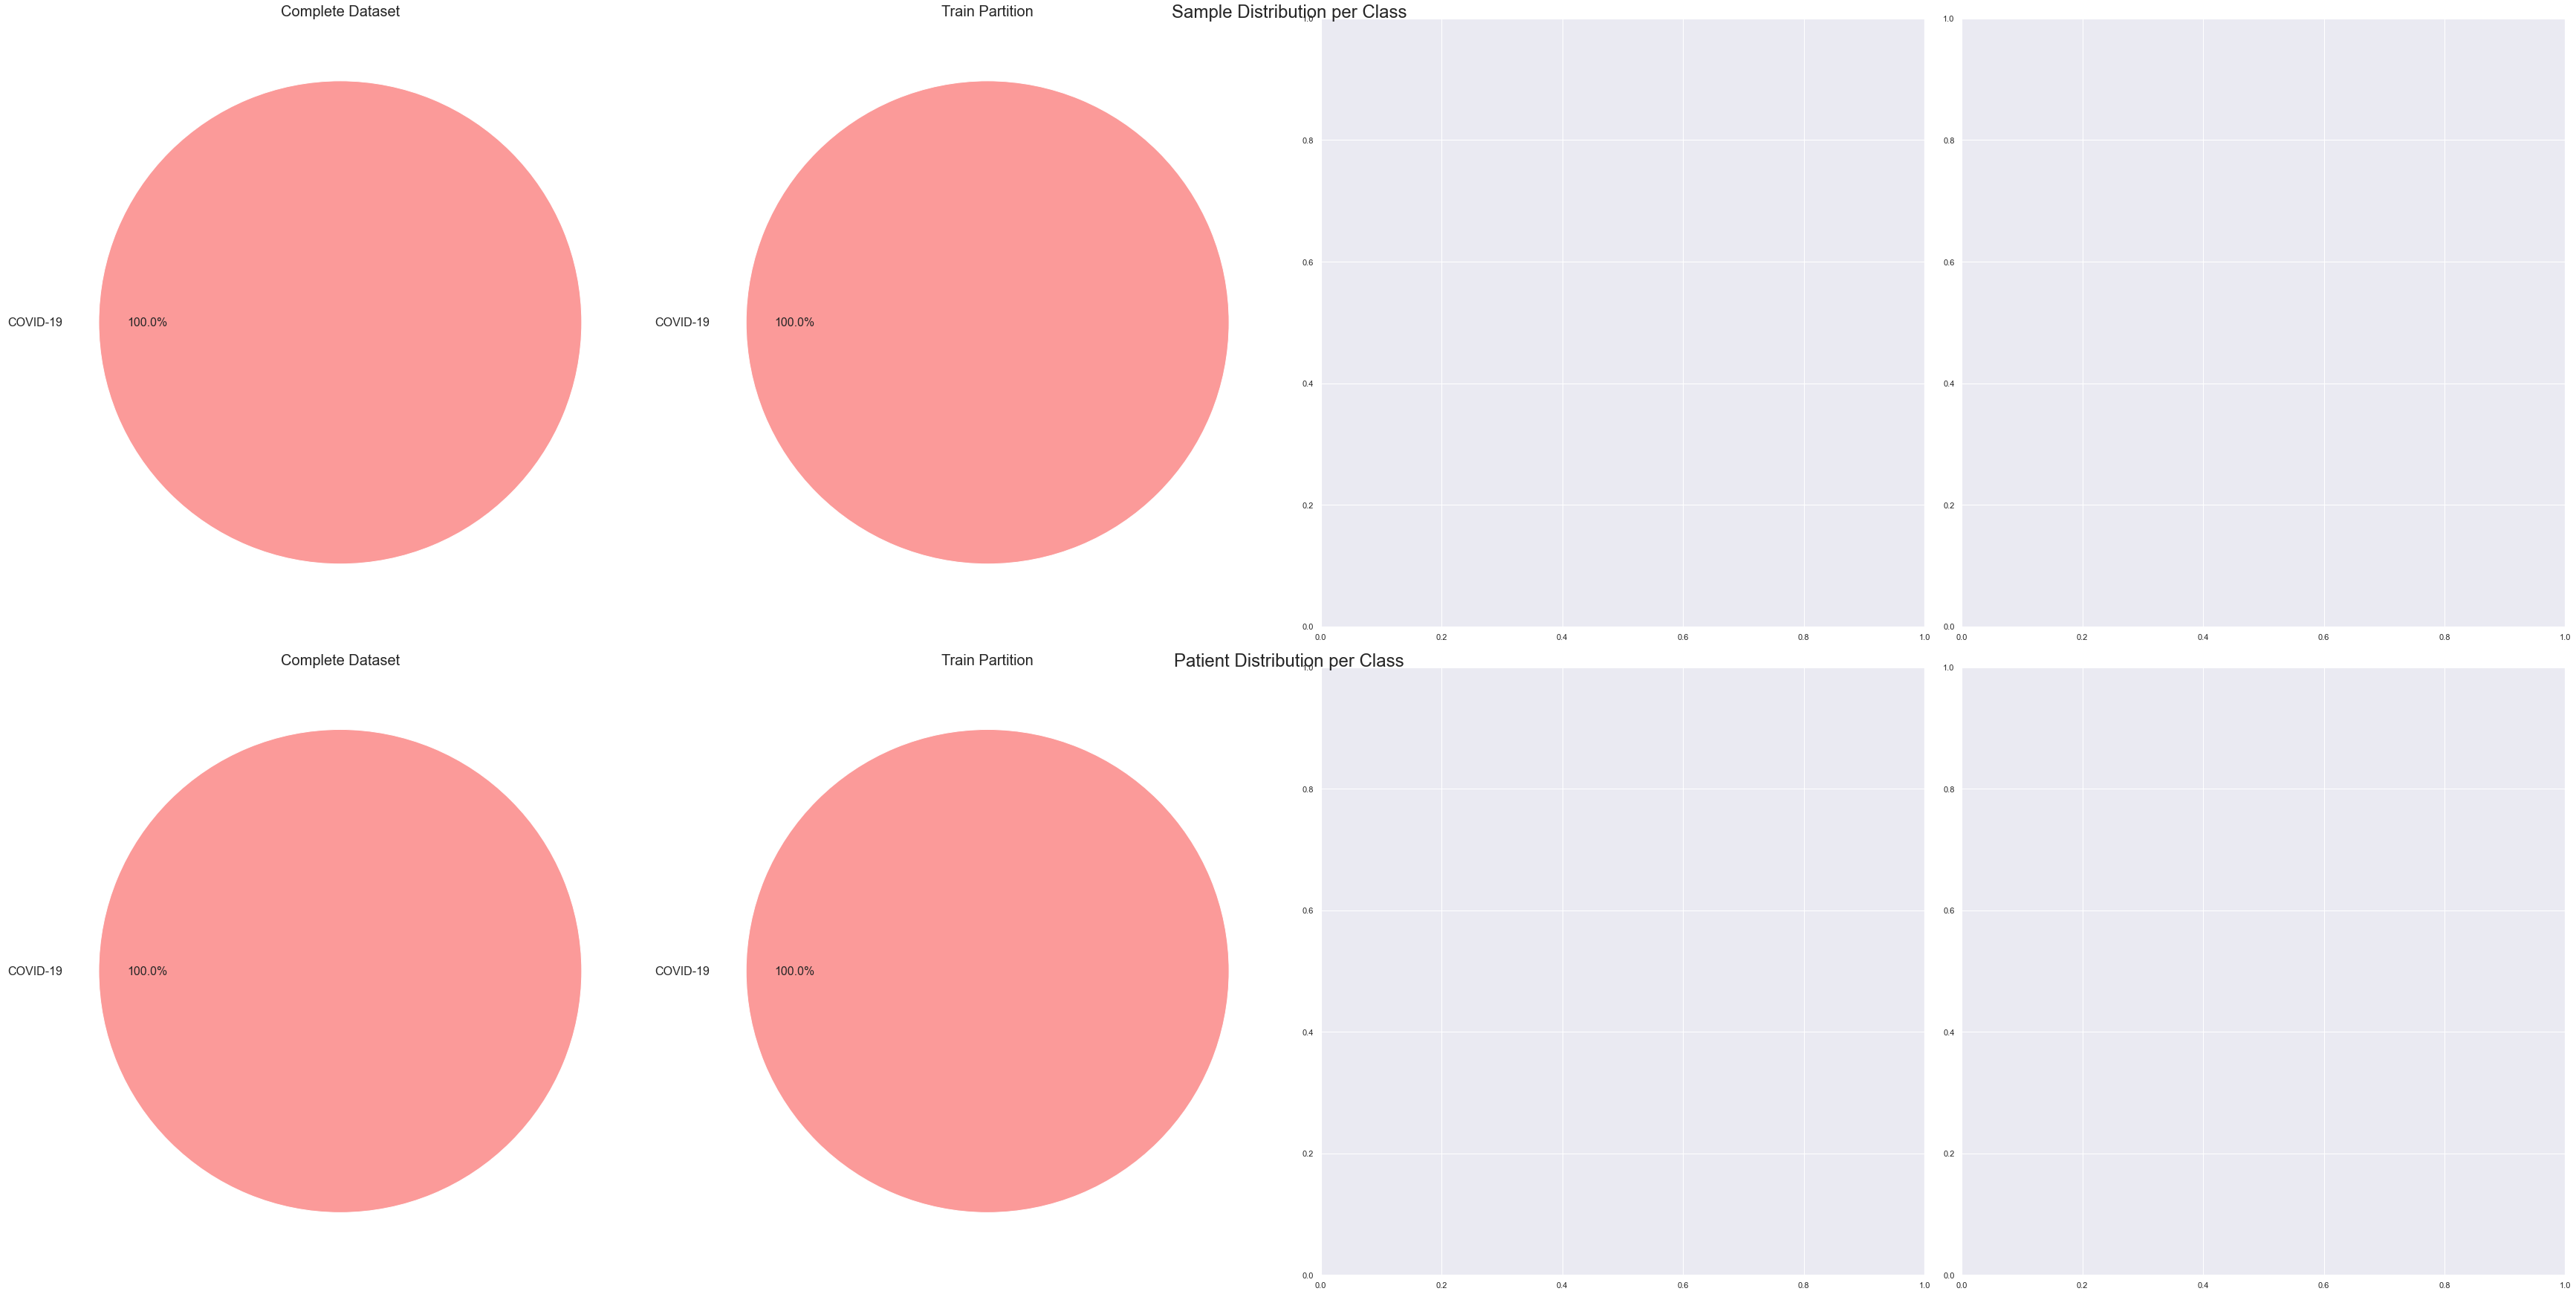

In [7]:
plot.column_as_pies( samples_df, patient_df, "class", dataset_name, figsize = (48, 24) )

In [8]:
plot.column_as_table( samples_df, patient_df, "class", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
COVID-19,14461,14461,0,0
Normal,0,0,0,0
Pneumonia,0,0,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
COVID-19,90,90,0,0
Pneumonia,0,0,0,0
Normal,0,0,0,0


## Age

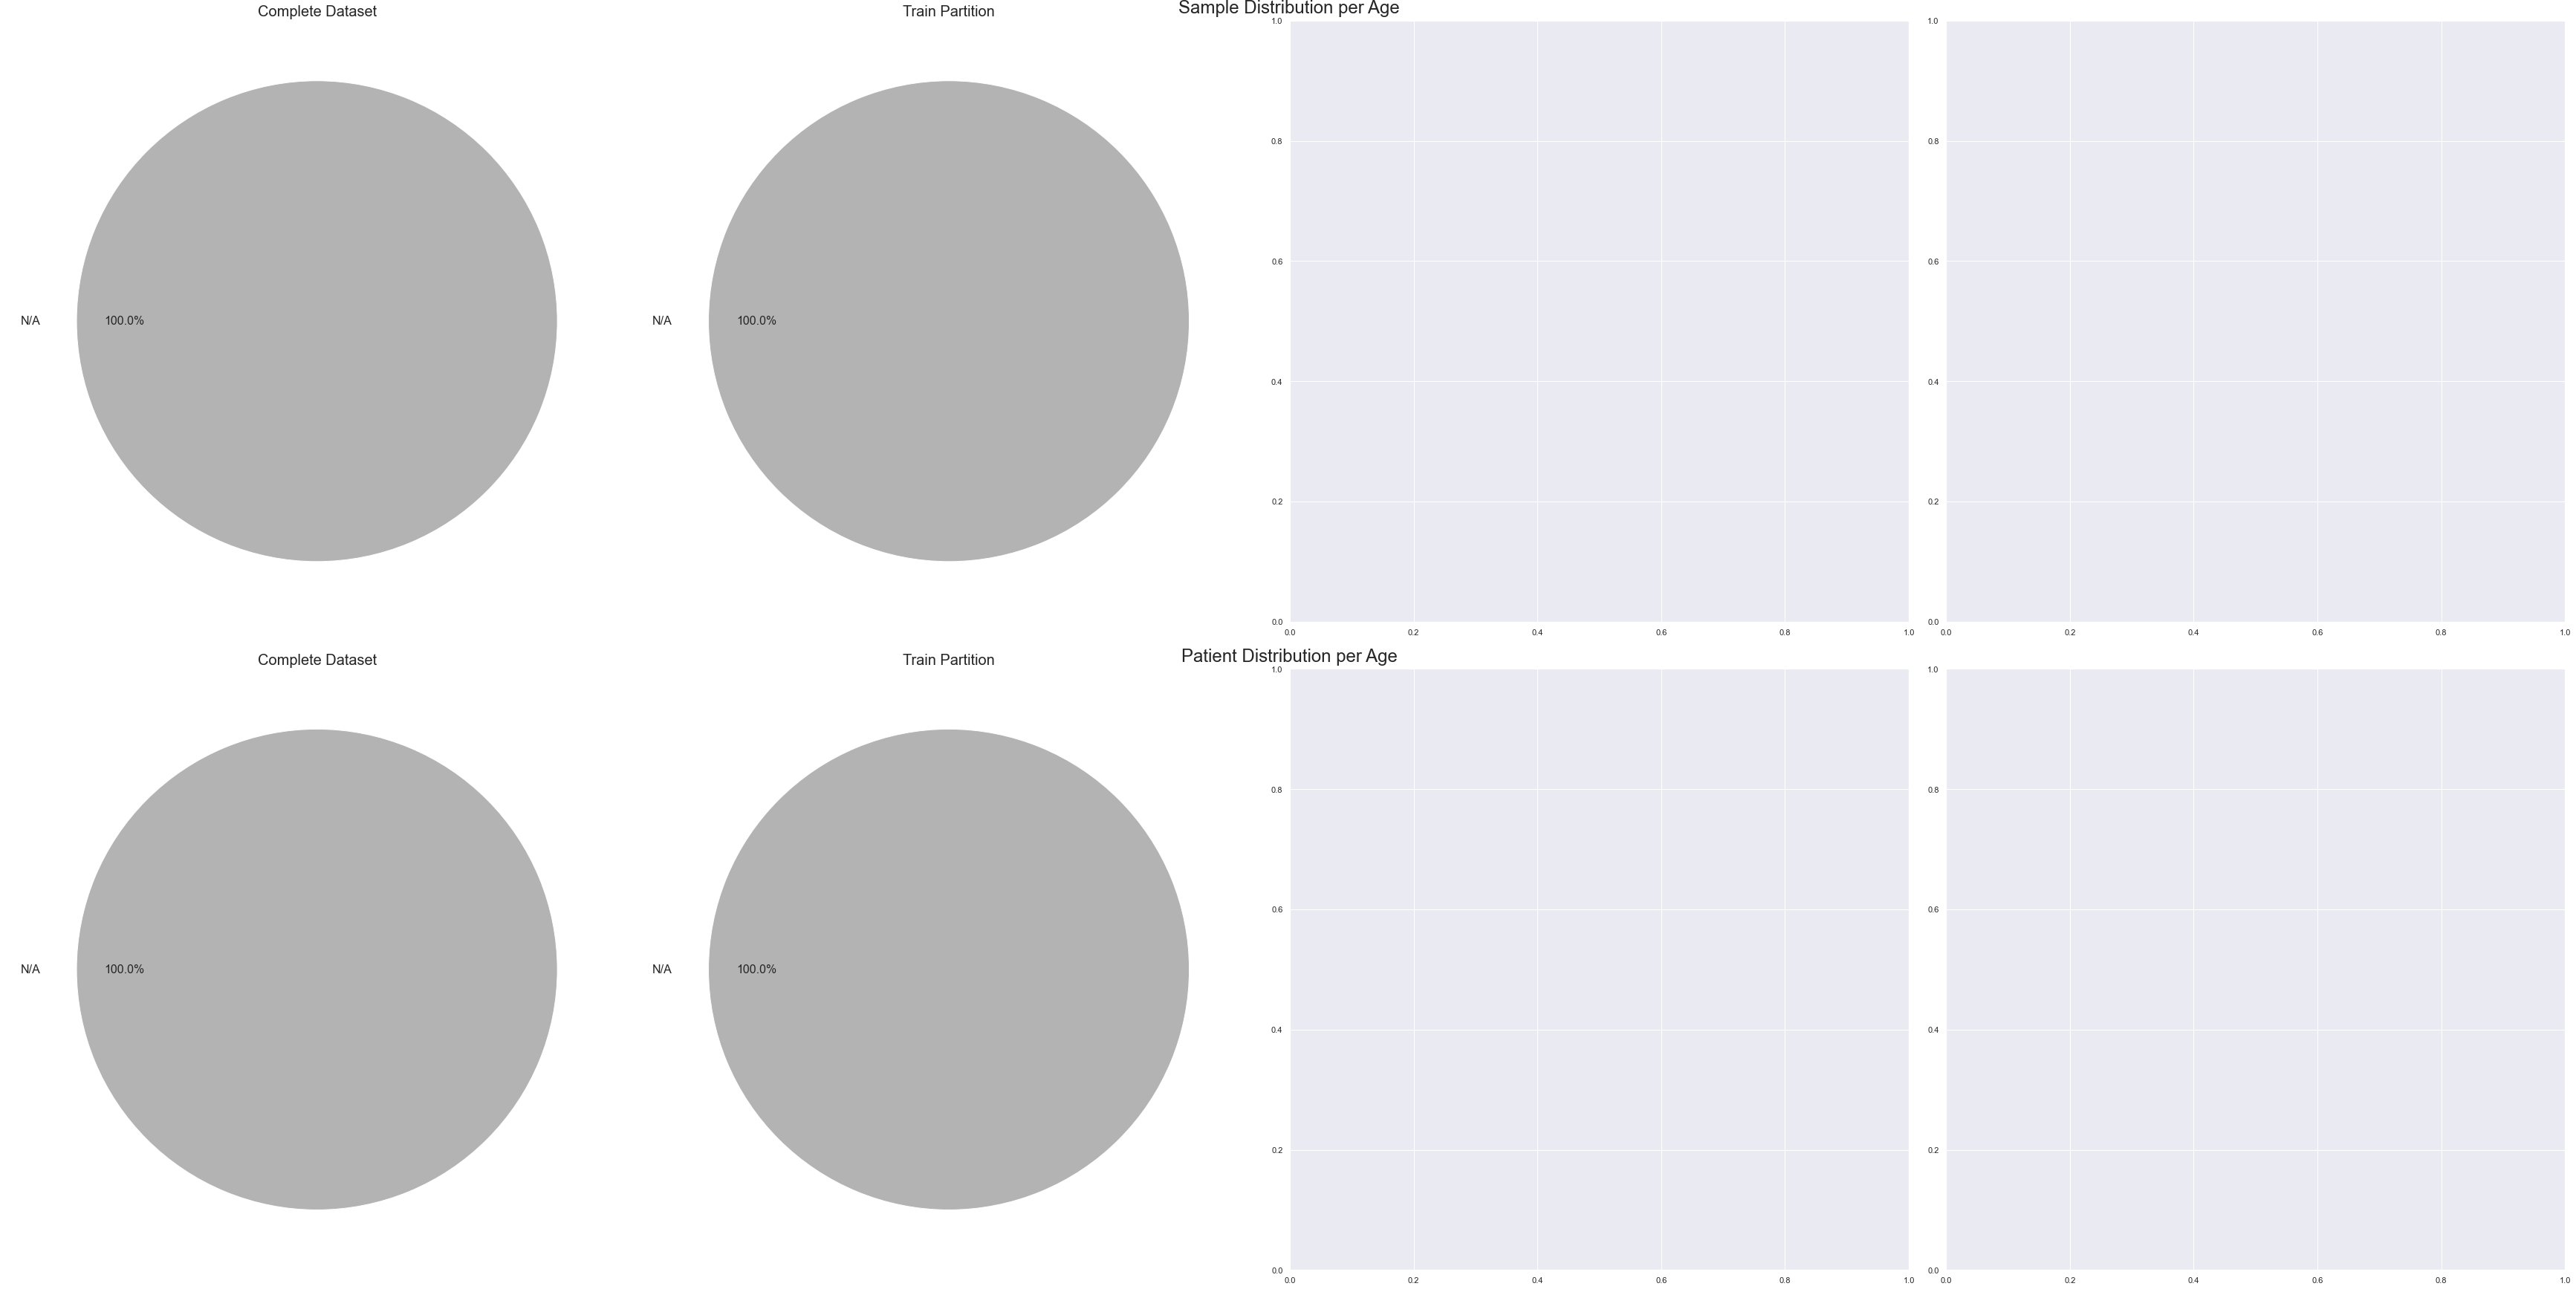

In [9]:
plot.column_as_pies( samples_df, patient_df, "age", dataset_name, figsize = (48, 24))

In [10]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
N/A,14461,14461,0,0
Known Ages,0,0,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
N/A,90,90,0,0
Known Ages,0,0,0,0
SUM,90,90,0,0


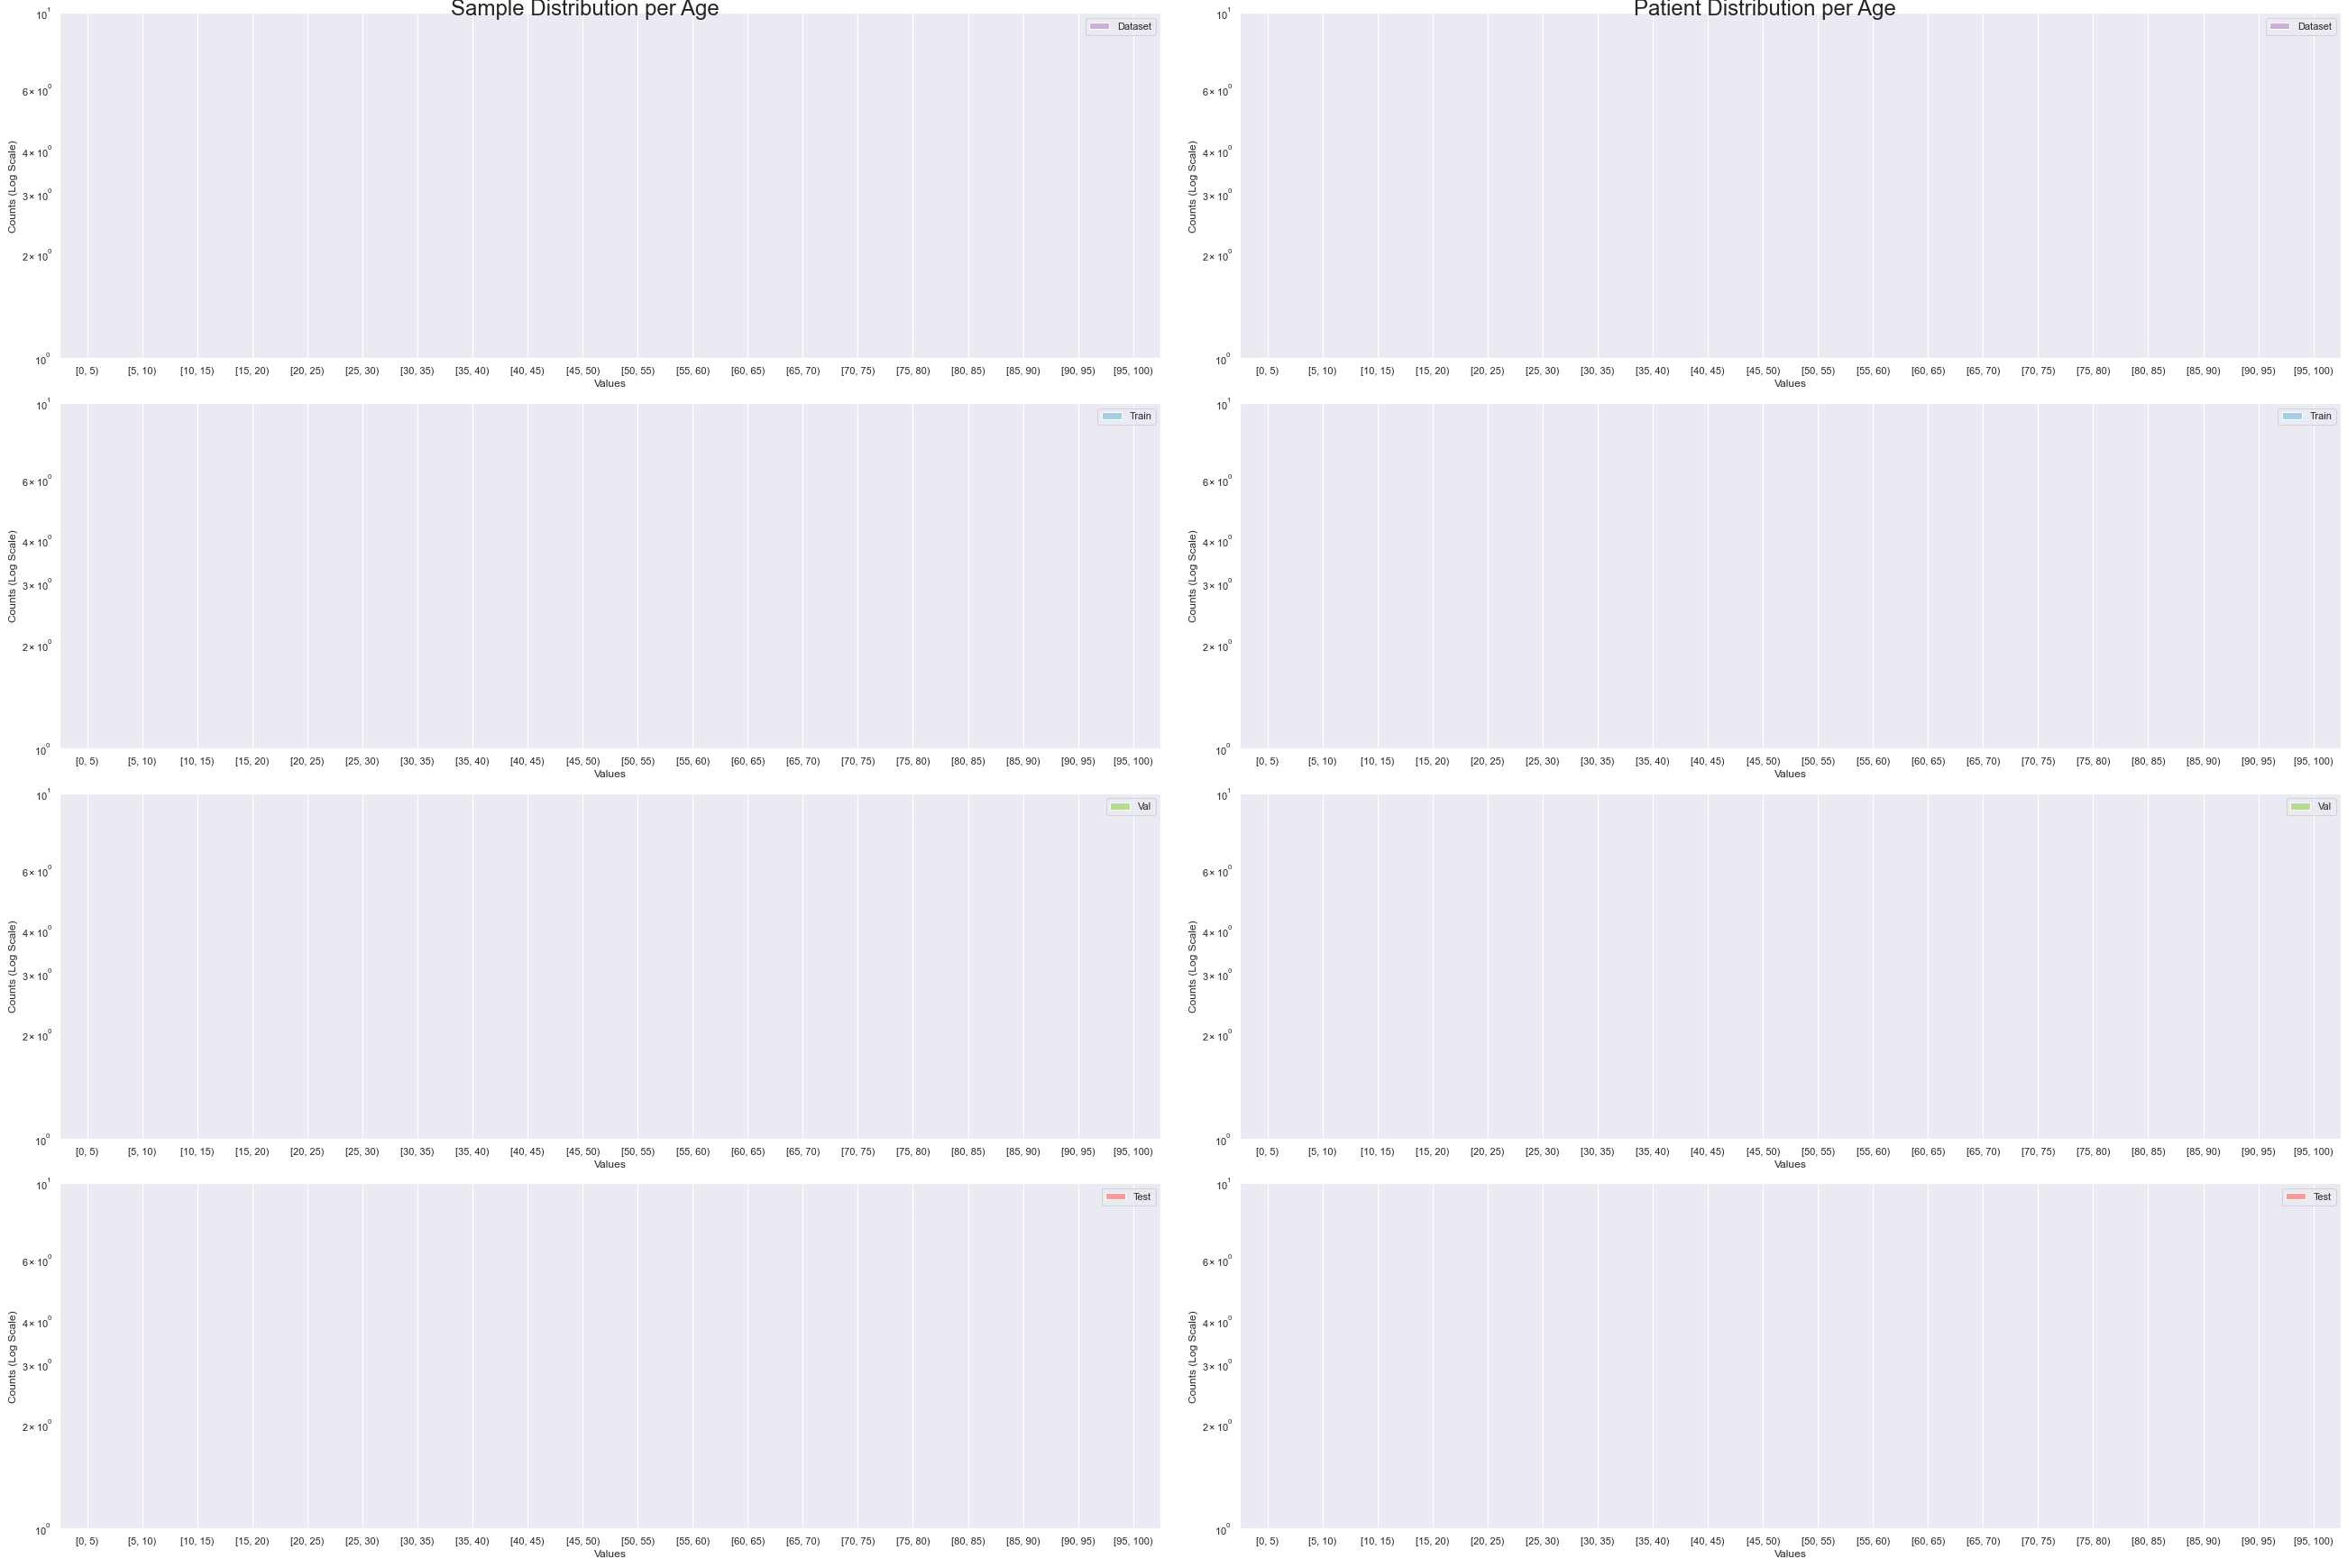

In [11]:
plot.column_as_histograms( samples_df, patient_df, "age", dataset_name, figsize = (36, 24))

In [12]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = True )

,Dataset,Train,Val,Test
Values,,,,
"[0, 5)",0,0,0,0
"[5, 10)",0,0,0,0
"[10, 15)",0,0,0,0
"[15, 20)",0,0,0,0
"[20, 25)",0,0,0,0
"[25, 30)",0,0,0,0
"[30, 35)",0,0,0,0
"[35, 40)",0,0,0,0
"[40, 45)",0,0,0,0


## Sex

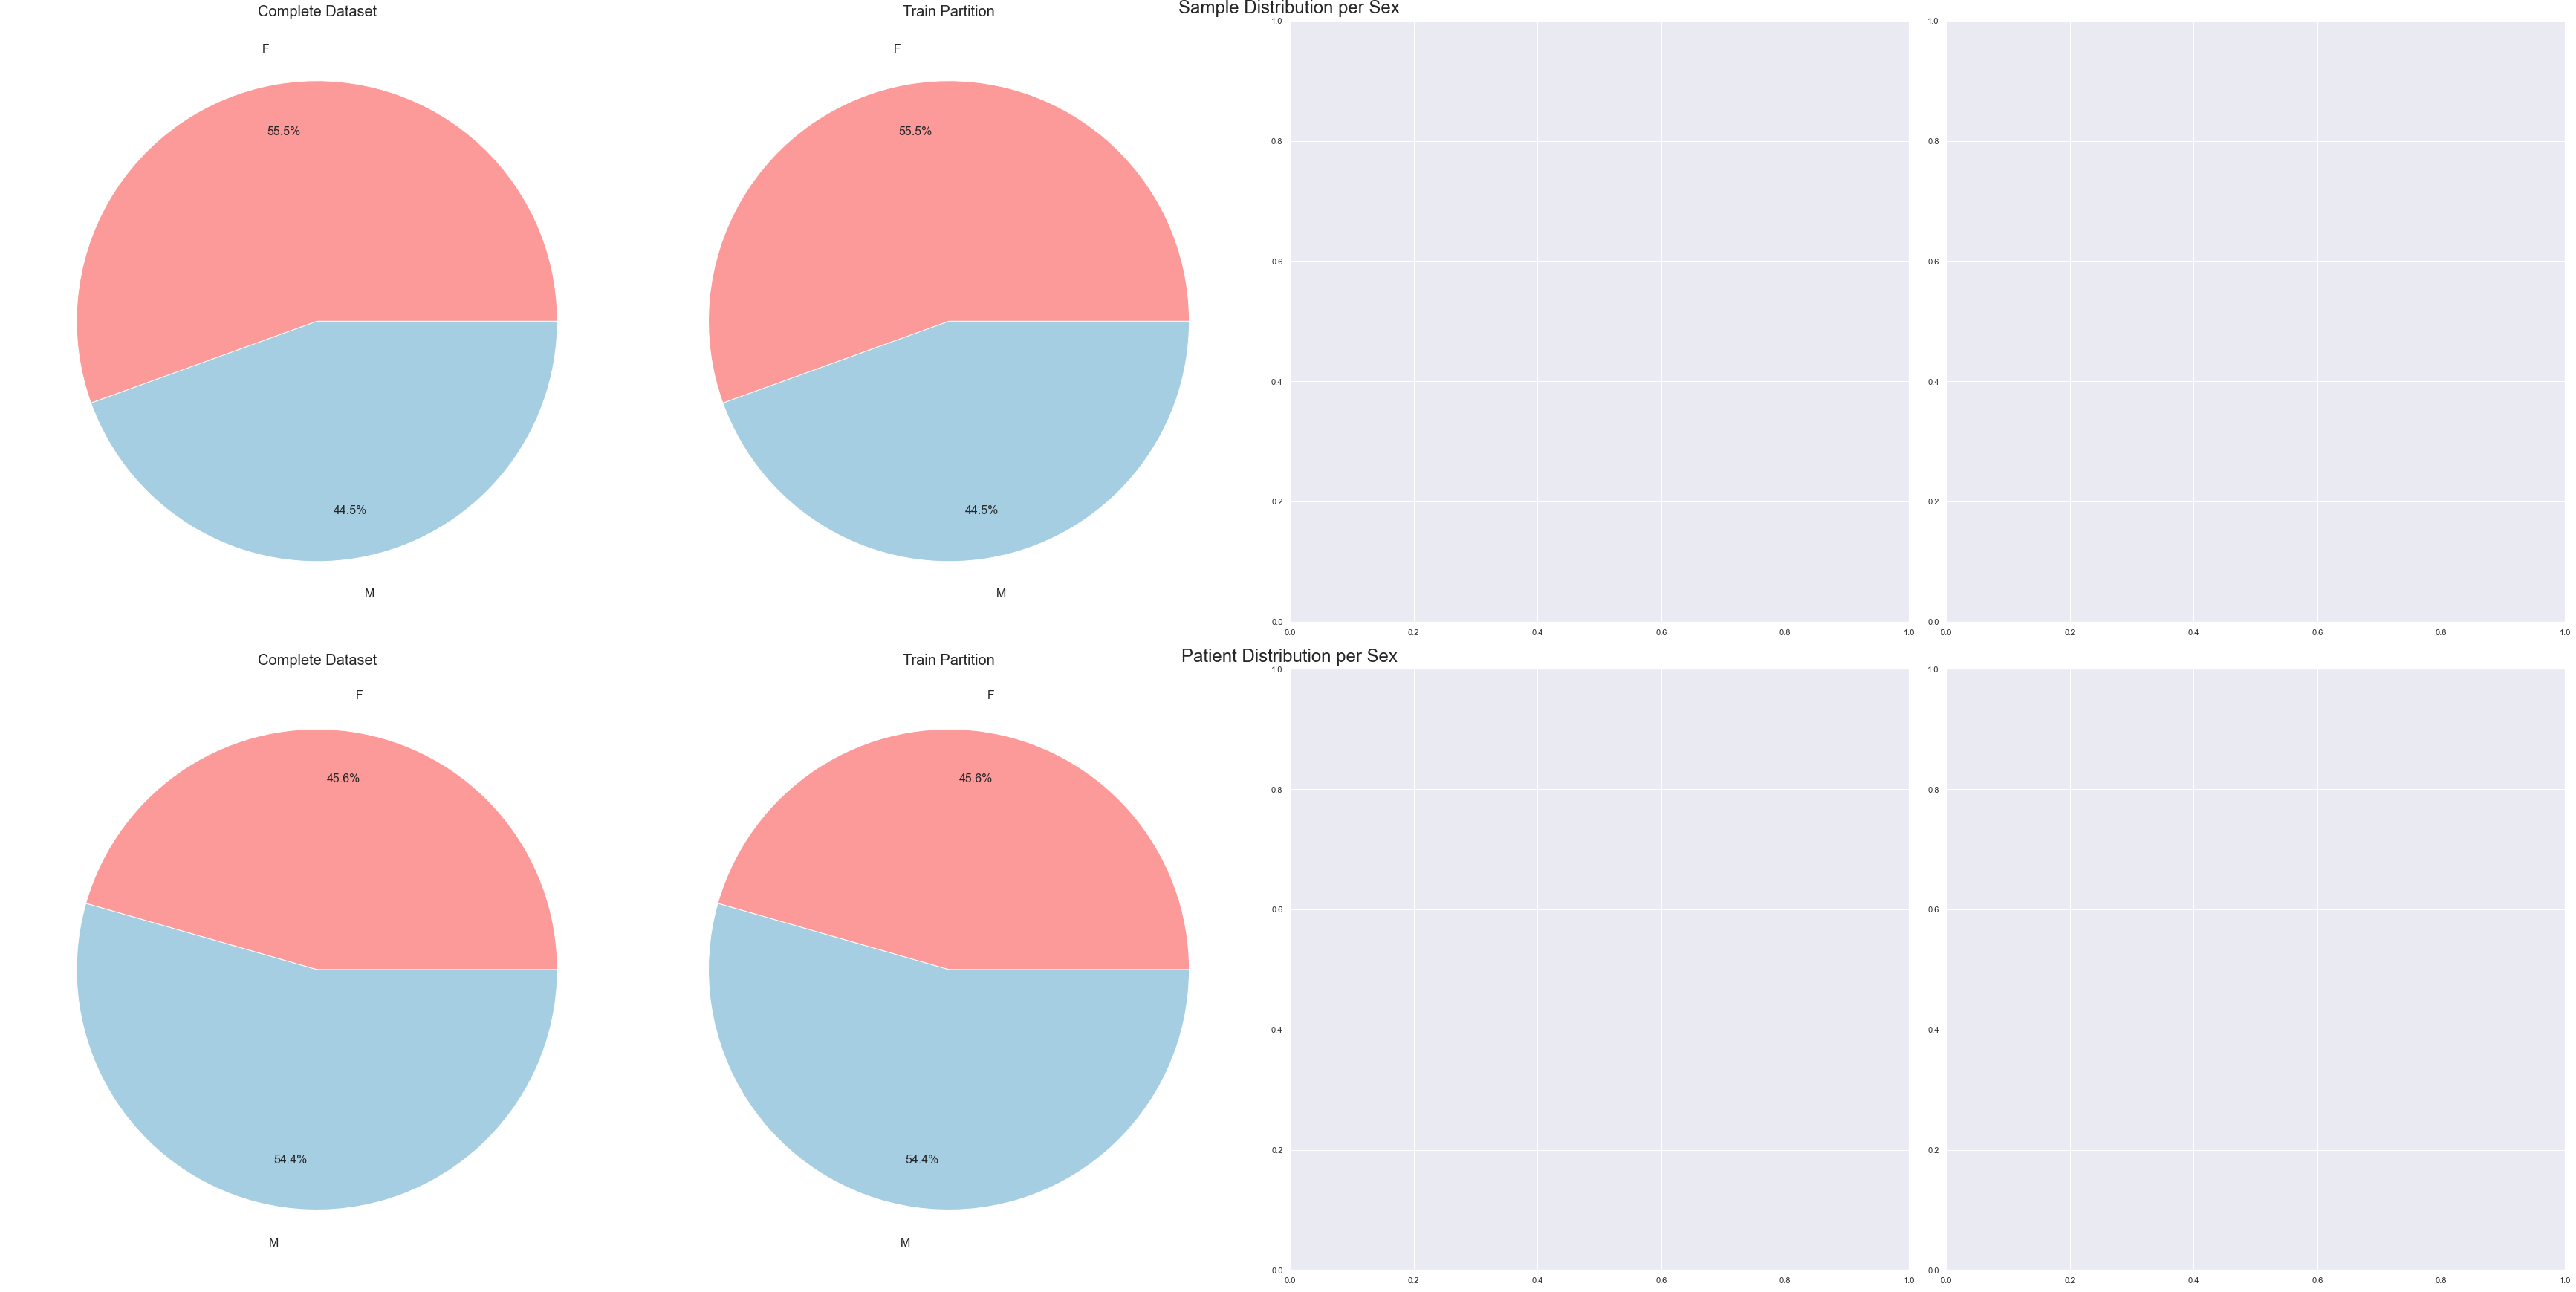

In [13]:
plot.column_as_pies( samples_df, patient_df, "sex", dataset_name, figsize = (48, 24) )

In [14]:
plot.column_as_table( samples_df, patient_df, "sex", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
M,6431,6431,0,0
N/A,0,0,0,0
F,8030,8030,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
N/A,0,0,0,0
M,49,49,0,0
F,41,41,0,0


## Country

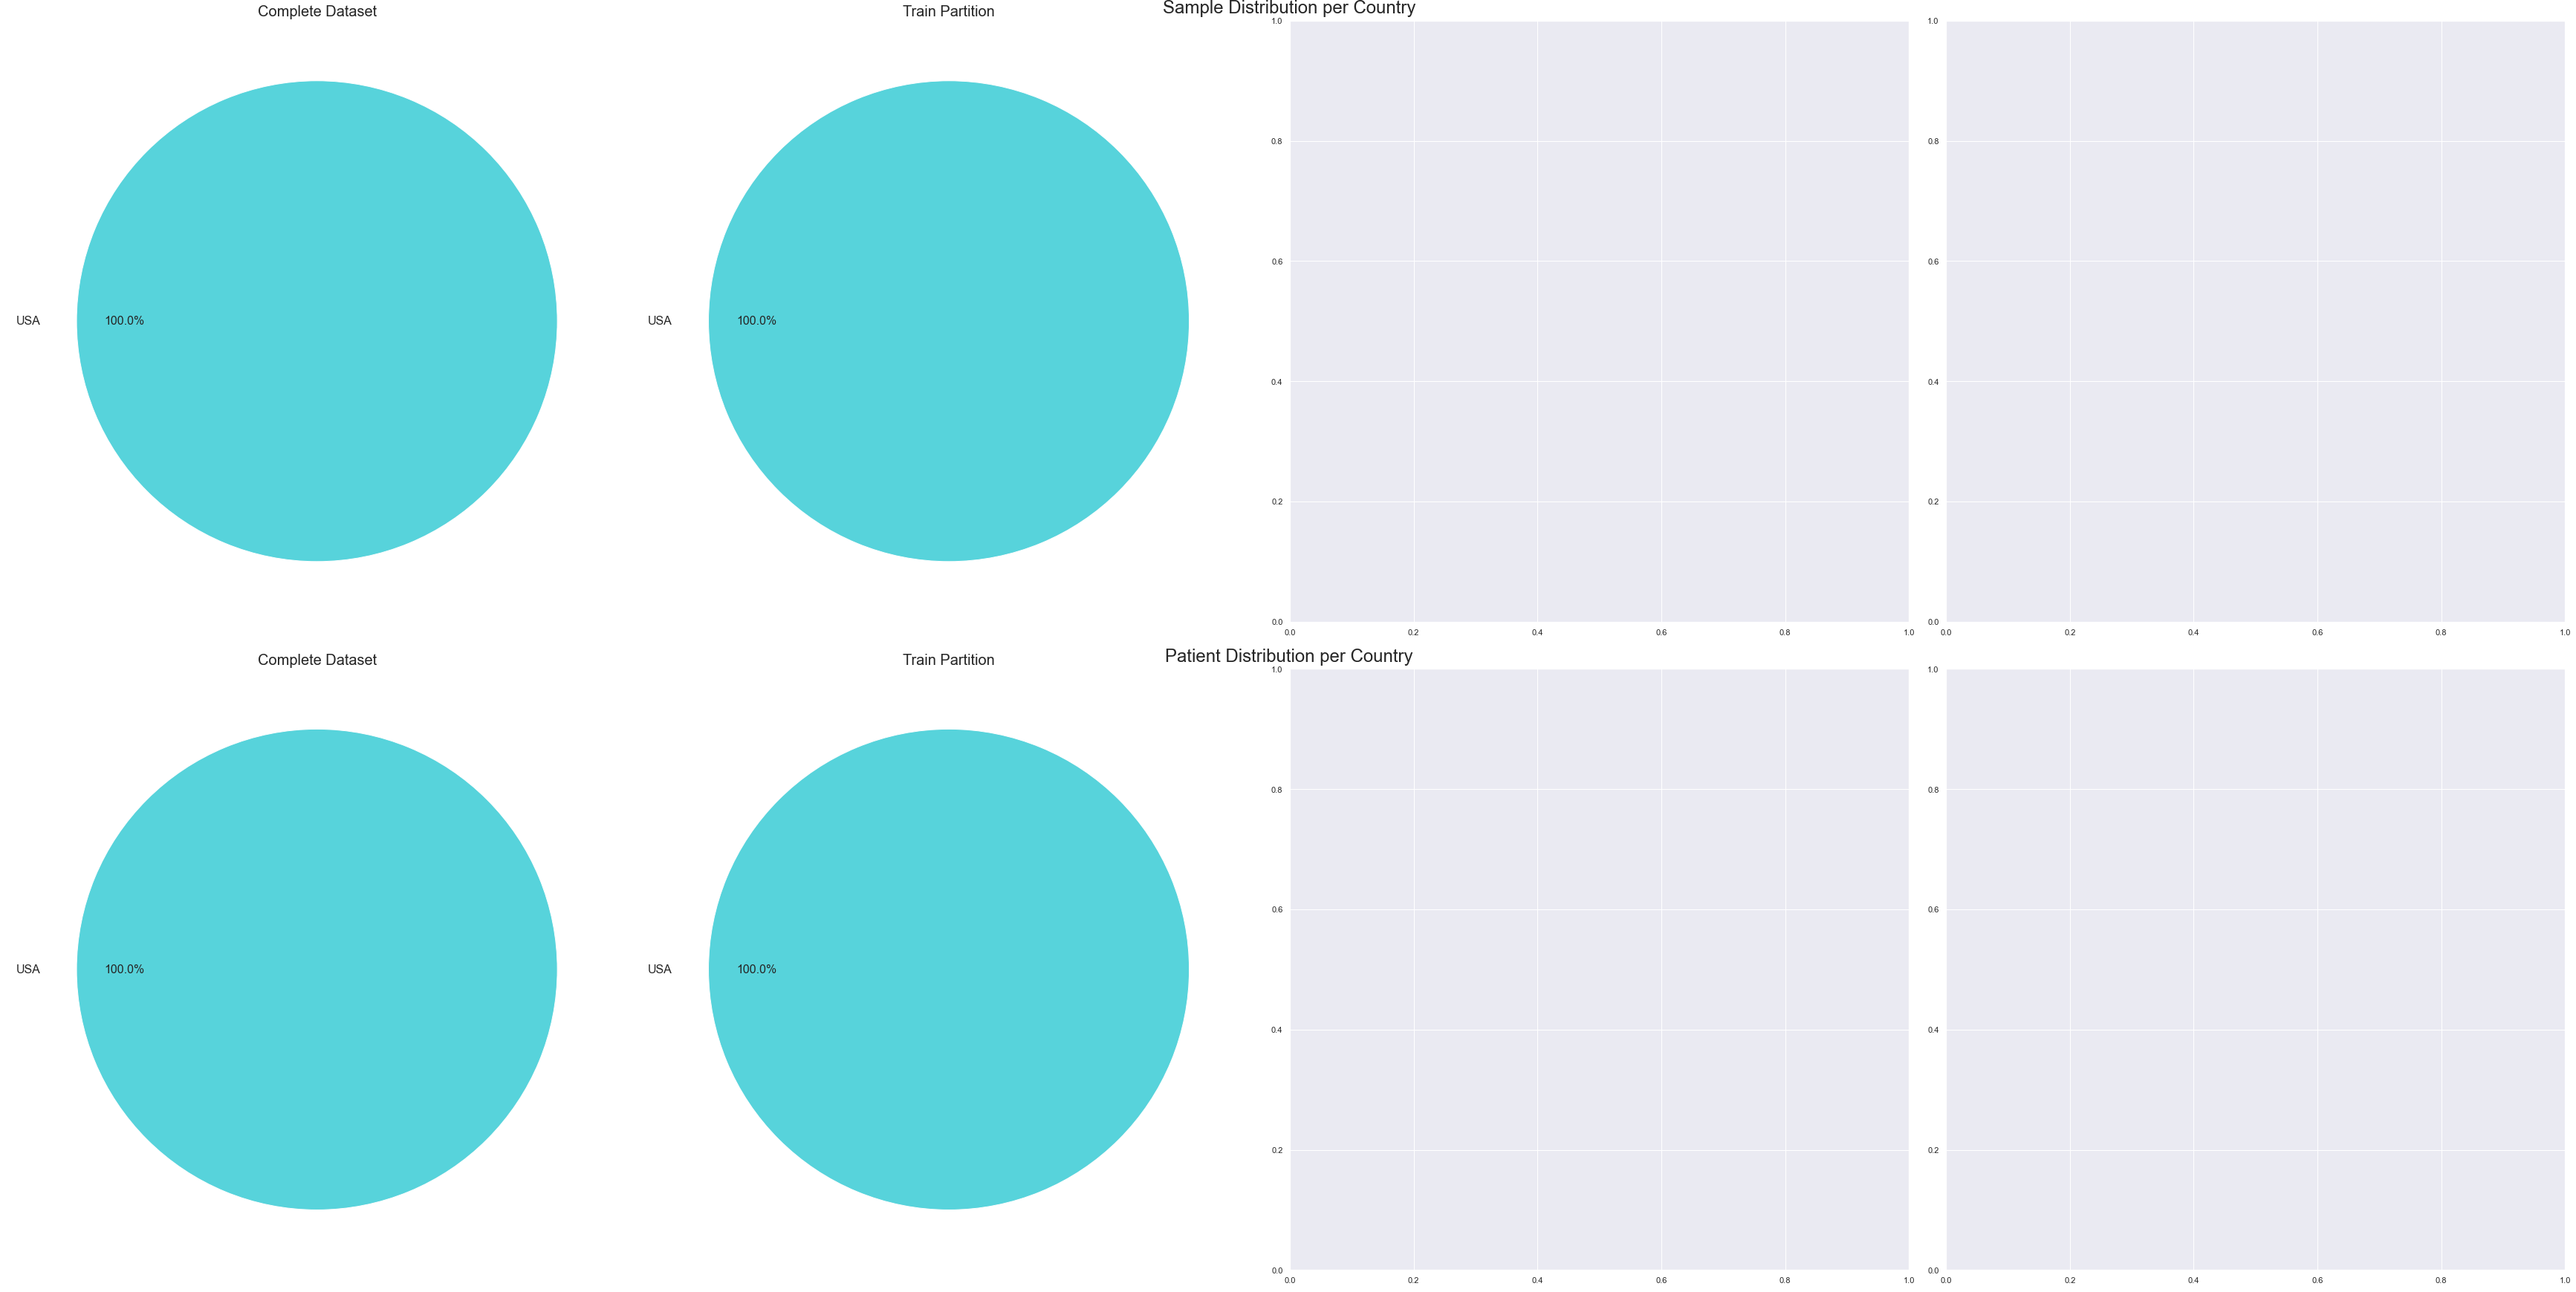

In [15]:
plot.column_as_pies( samples_df, patient_df, "country", dataset_name, figsize = (48, 24) )

In [16]:
plot.column_as_table( samples_df, patient_df, "country", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
France,0,0,0,0
China,0,0,0,0
Iran,0,0,0,0
USA,14461,14461,0,0
N/A,0,0,0,0
Australia,0,0,0,0
Italy,0,0,0,0
Algeria,0,0,0,0
Belgium,0,0,0,0


## Partition

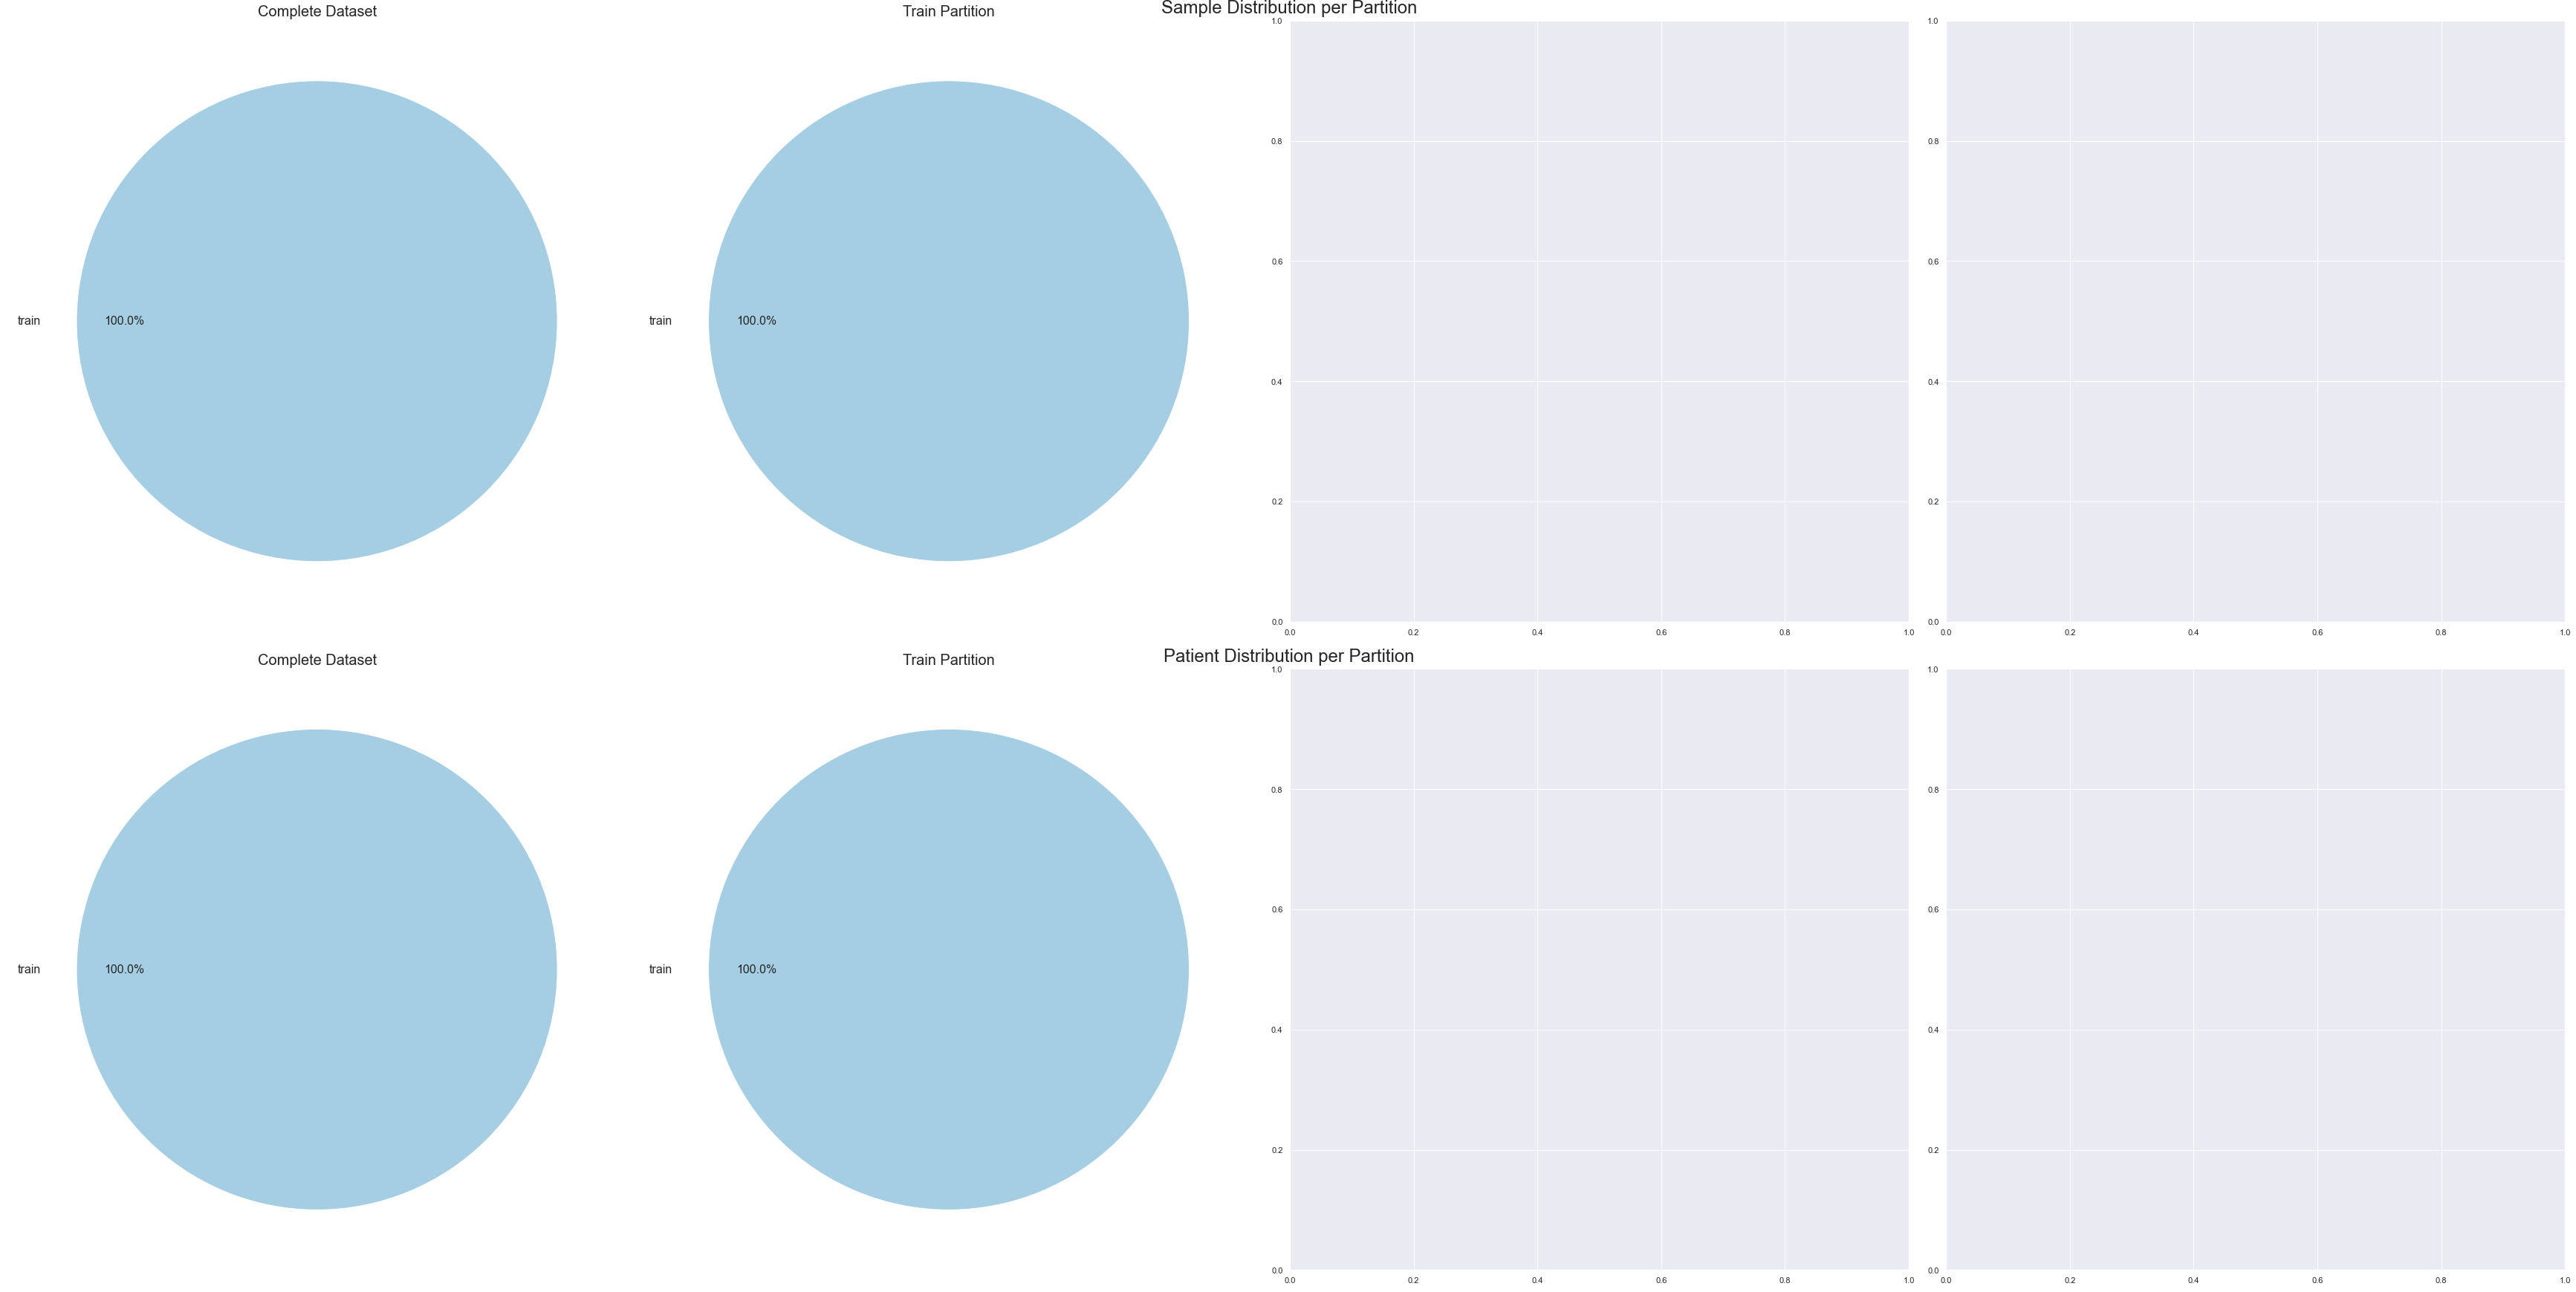

In [17]:
plot.column_as_pies( samples_df, patient_df, "partition", dataset_name, figsize = (48, 24) )

In [18]:
plot.column_as_table( samples_df, patient_df, "partition", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
train,14461,14461,0,0
test,0,0,0,0
val,0,0,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
train,90,90,0,0
val,0,0,0,0
test,0,0,0,0


## Slice Selection

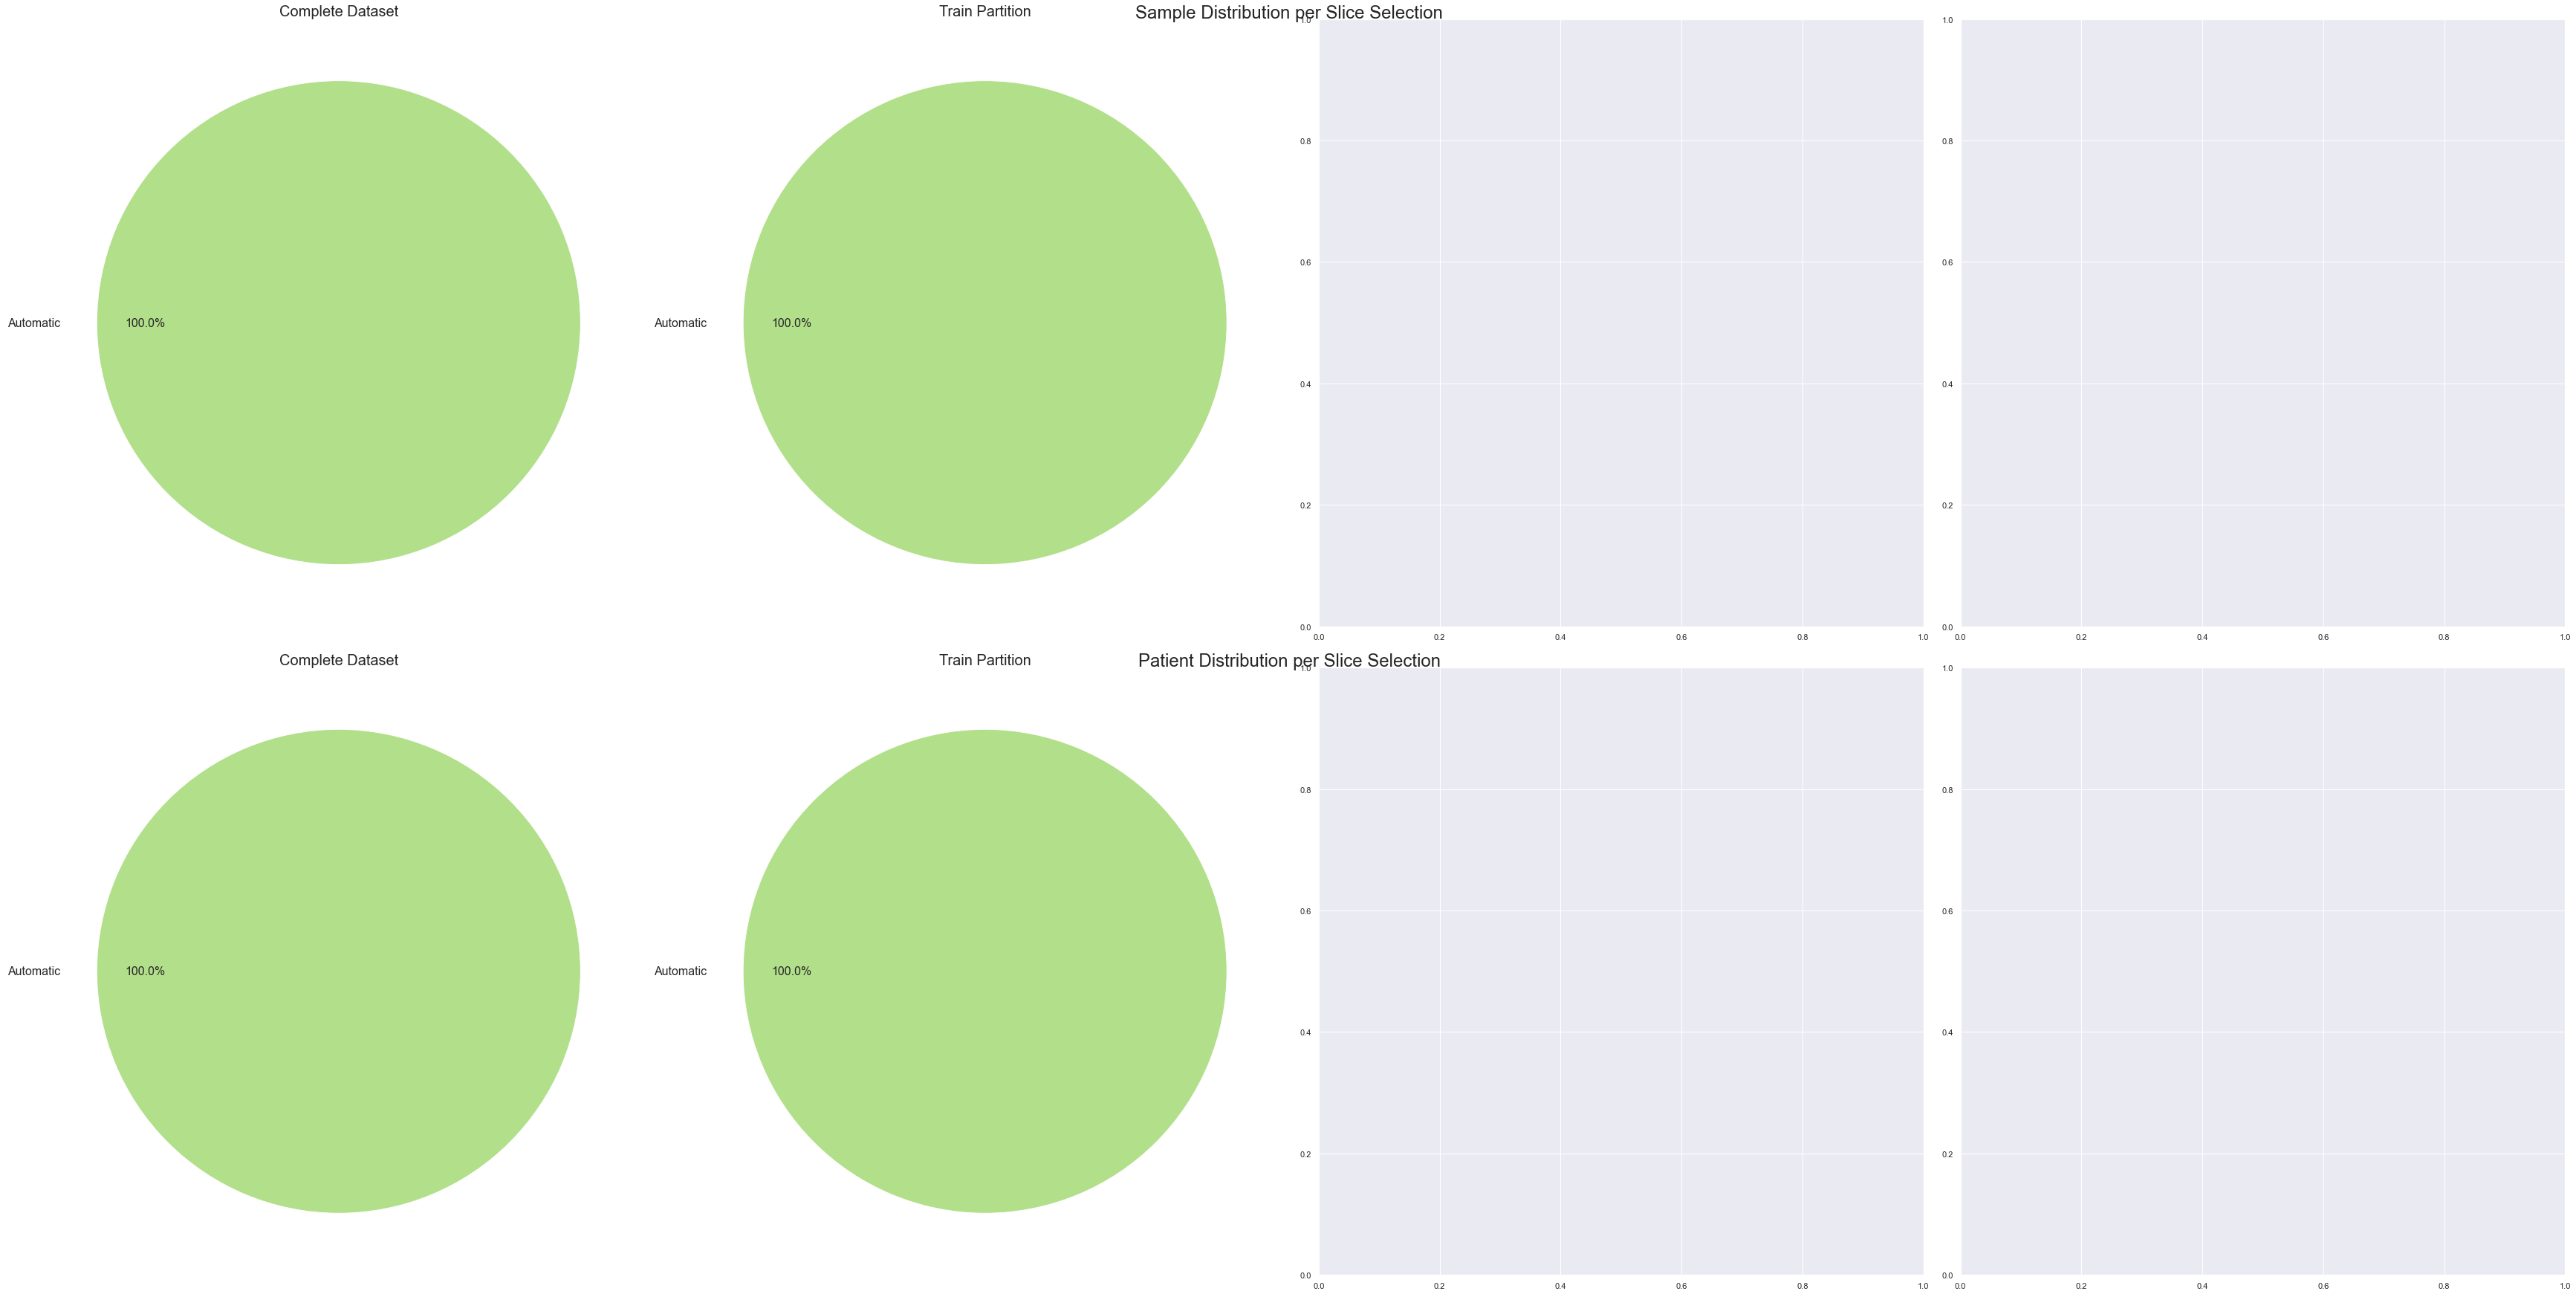

In [19]:
plot.column_as_pies( samples_df, patient_df, "slice_selection", dataset_name, figsize = (48, 24) )

In [20]:
plot.column_as_table( samples_df, patient_df, "slice_selection", dataset_name, bin_flag = False )

,Dataset,Train,Val,Test
Values,,,,
Automatic,14461,14461,0,0
Expert,0,0,0,0
N/A,0,0,0,0
Non-expert,0,0,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
Automatic,90,90,0,0
Expert,0,0,0,0


# Data Split

In [21]:
new_samples_df, new_patient_df = split.radiopaedia_dataset_by_samples( samples_df, patient_df, dataset_name, sample_frac = 0.2, seed = 20 )

    1/1: Group ('N/A', 'COVID-19', 'Automatic', 'N/A', 'N/A')
	[Test] Moved 2890 samples (19 patients), expected 2892 samples, had 14461 samples (90 patients)...
		List of sample counts: [227, 142, 234, 230, 65, 150, 41, 71, 194, 291, 210, 92, 205, 356, 141, 282, 37, 293, 107, 218, 218, 448, 19, 292, 78, 42, 20, 115, 22, 206, 45, 150, 39, 194, 194, 102, 797, 120, 151, 109, 106, 19, 397, 311, 91, 193, 341, 202, 215, 14, 163, 167, 185, 70, 138, 70, 426, 14, 214, 42, 57, 62, 20, 109, 99, 135, 51, 97, 164, 252, 200, 104, 52, 69, 18, 13, 170, 28, 54, 269, 104, 53, 354, 21, 168, 28, 916, 134, 146, 189]
	[Val] Moved 2880 samples (17 patients), expected 2892 samples, had 11571 samples (71 patients)...
		List of sample counts: [282, 293, 218, 218, 448, 292, 42, 20, 115, 22, 206, 45, 150, 39, 194, 194, 102, 797, 120, 151, 109, 106, 19, 397, 311, 91, 193, 341, 202, 215, 14, 163, 167, 185, 70, 138, 70, 426, 14, 214, 42, 57, 62, 20, 109, 99, 135, 51, 97, 164, 252, 200, 104, 52, 69, 18, 13, 170, 28,

# Post Split Plots

## Class

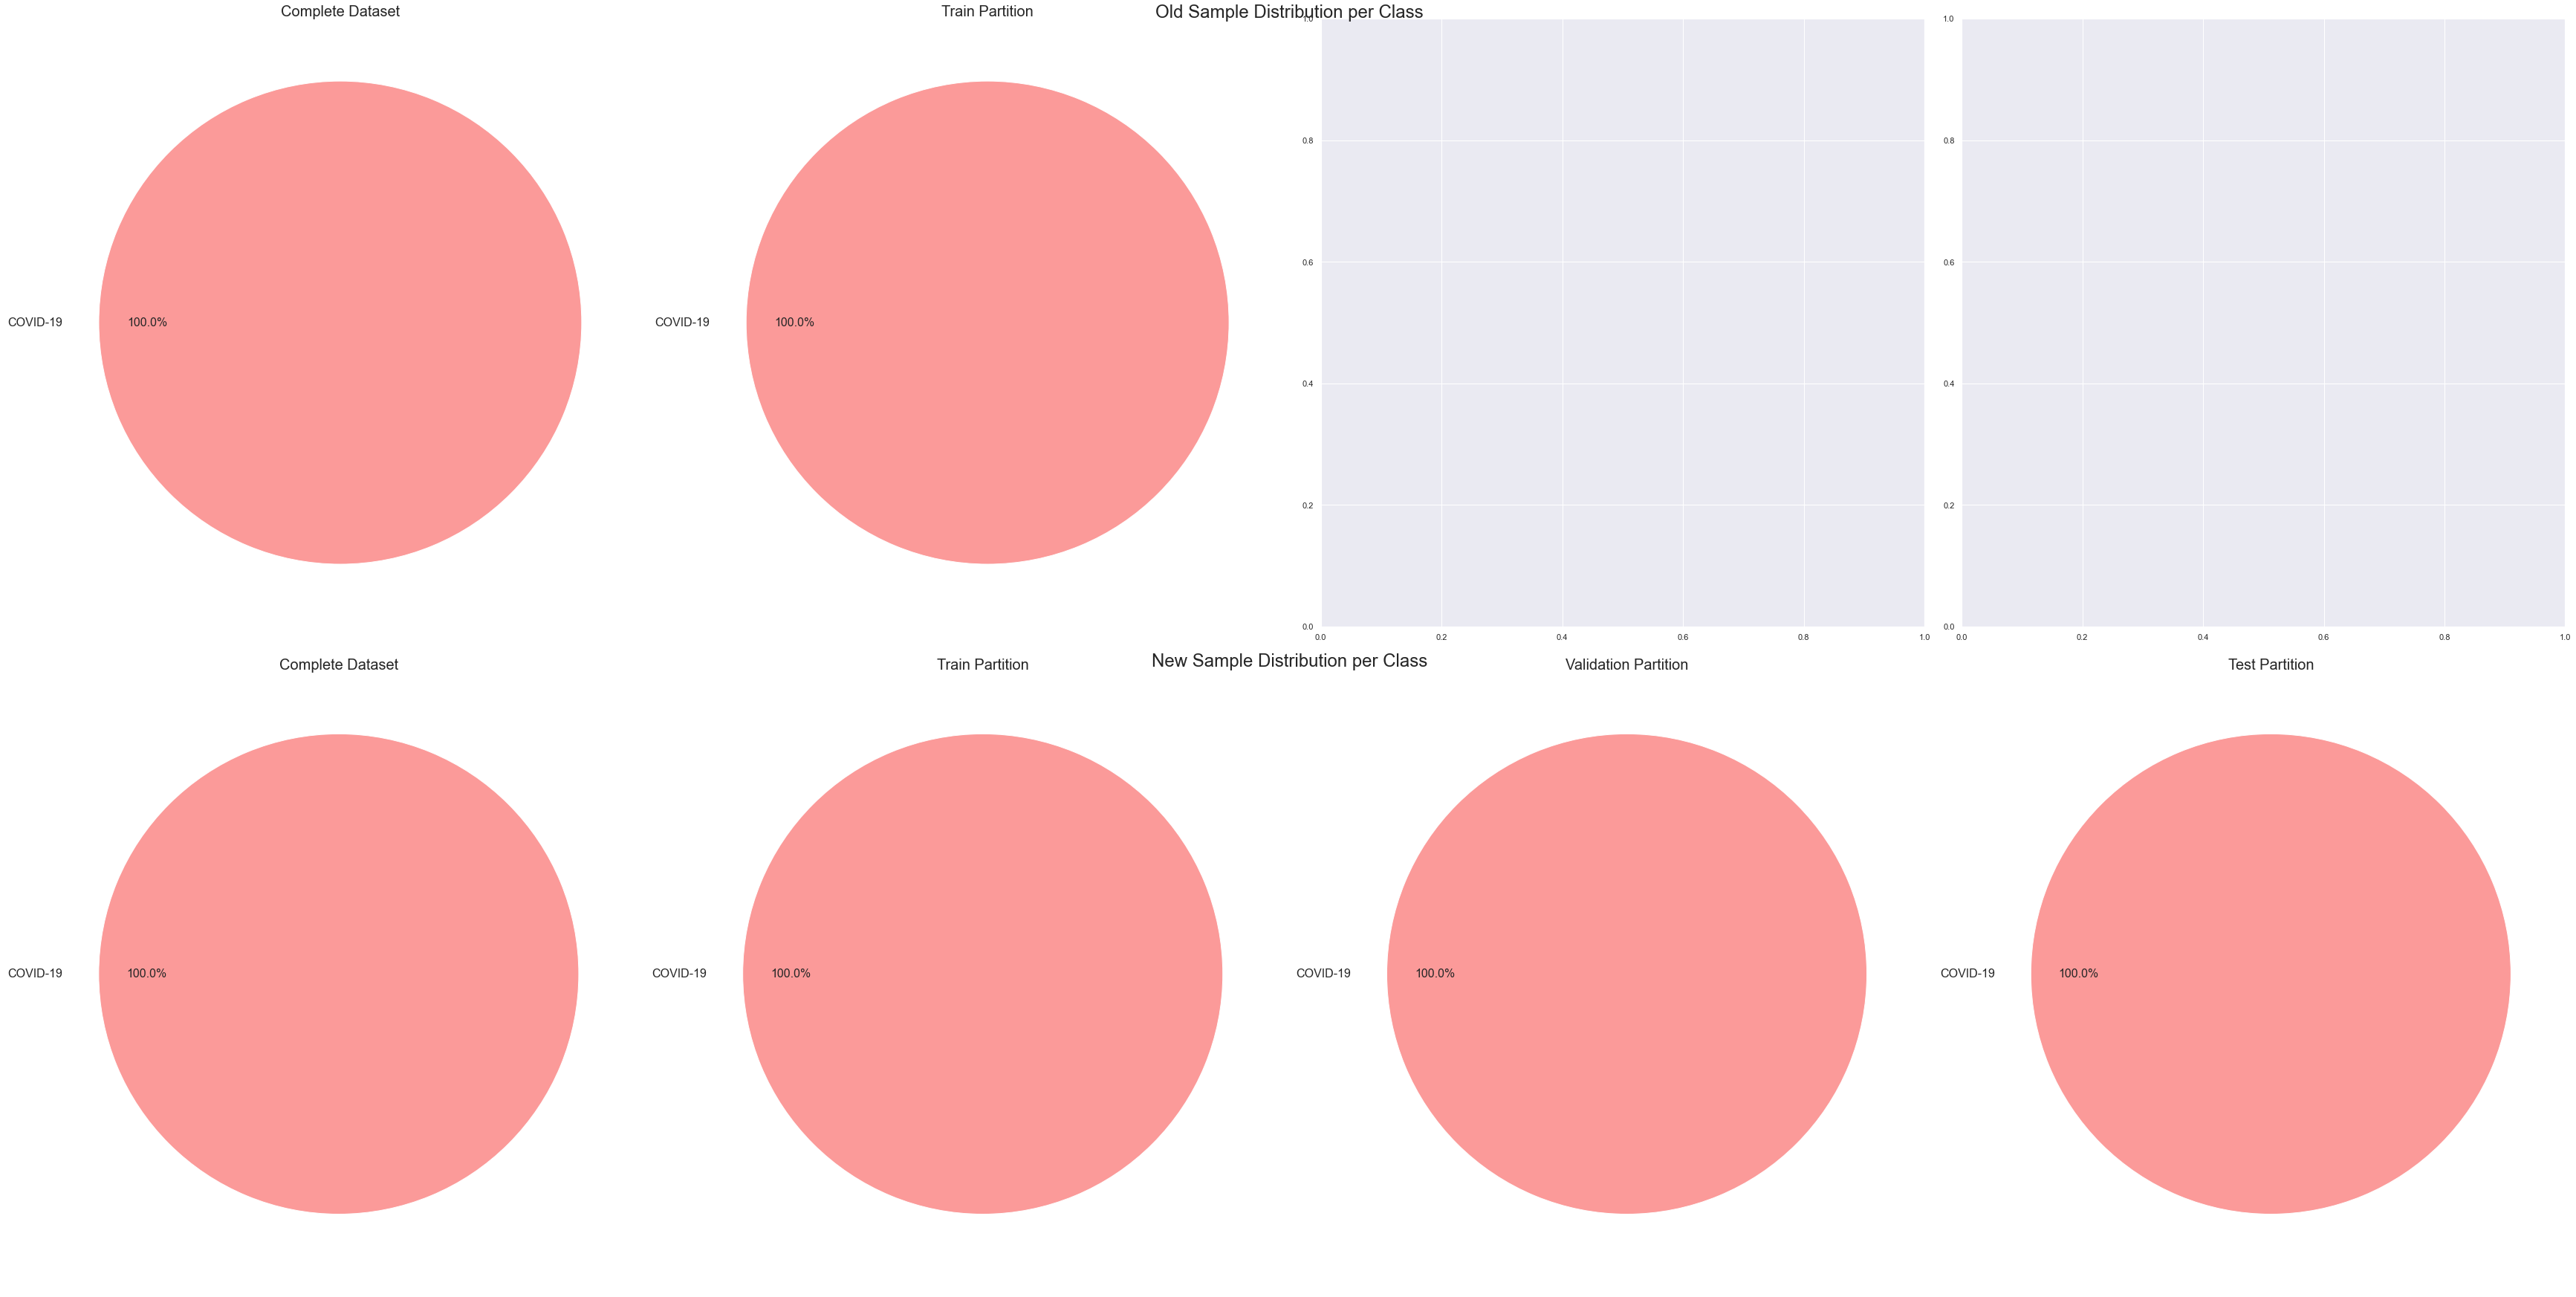

In [22]:
plot.column_as_pies( samples_df, new_samples_df, "class", dataset_name, figsize = (48, 24), resplit = True )

In [23]:
plot.column_as_table( samples_df, new_samples_df, "class", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
COVID-19,14461,14461,0,0
Normal,0,0,0,0
Pneumonia,0,0,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
COVID-19,14461,8691,2880,2890
SUM,14461,8691,2880,2890


## Age

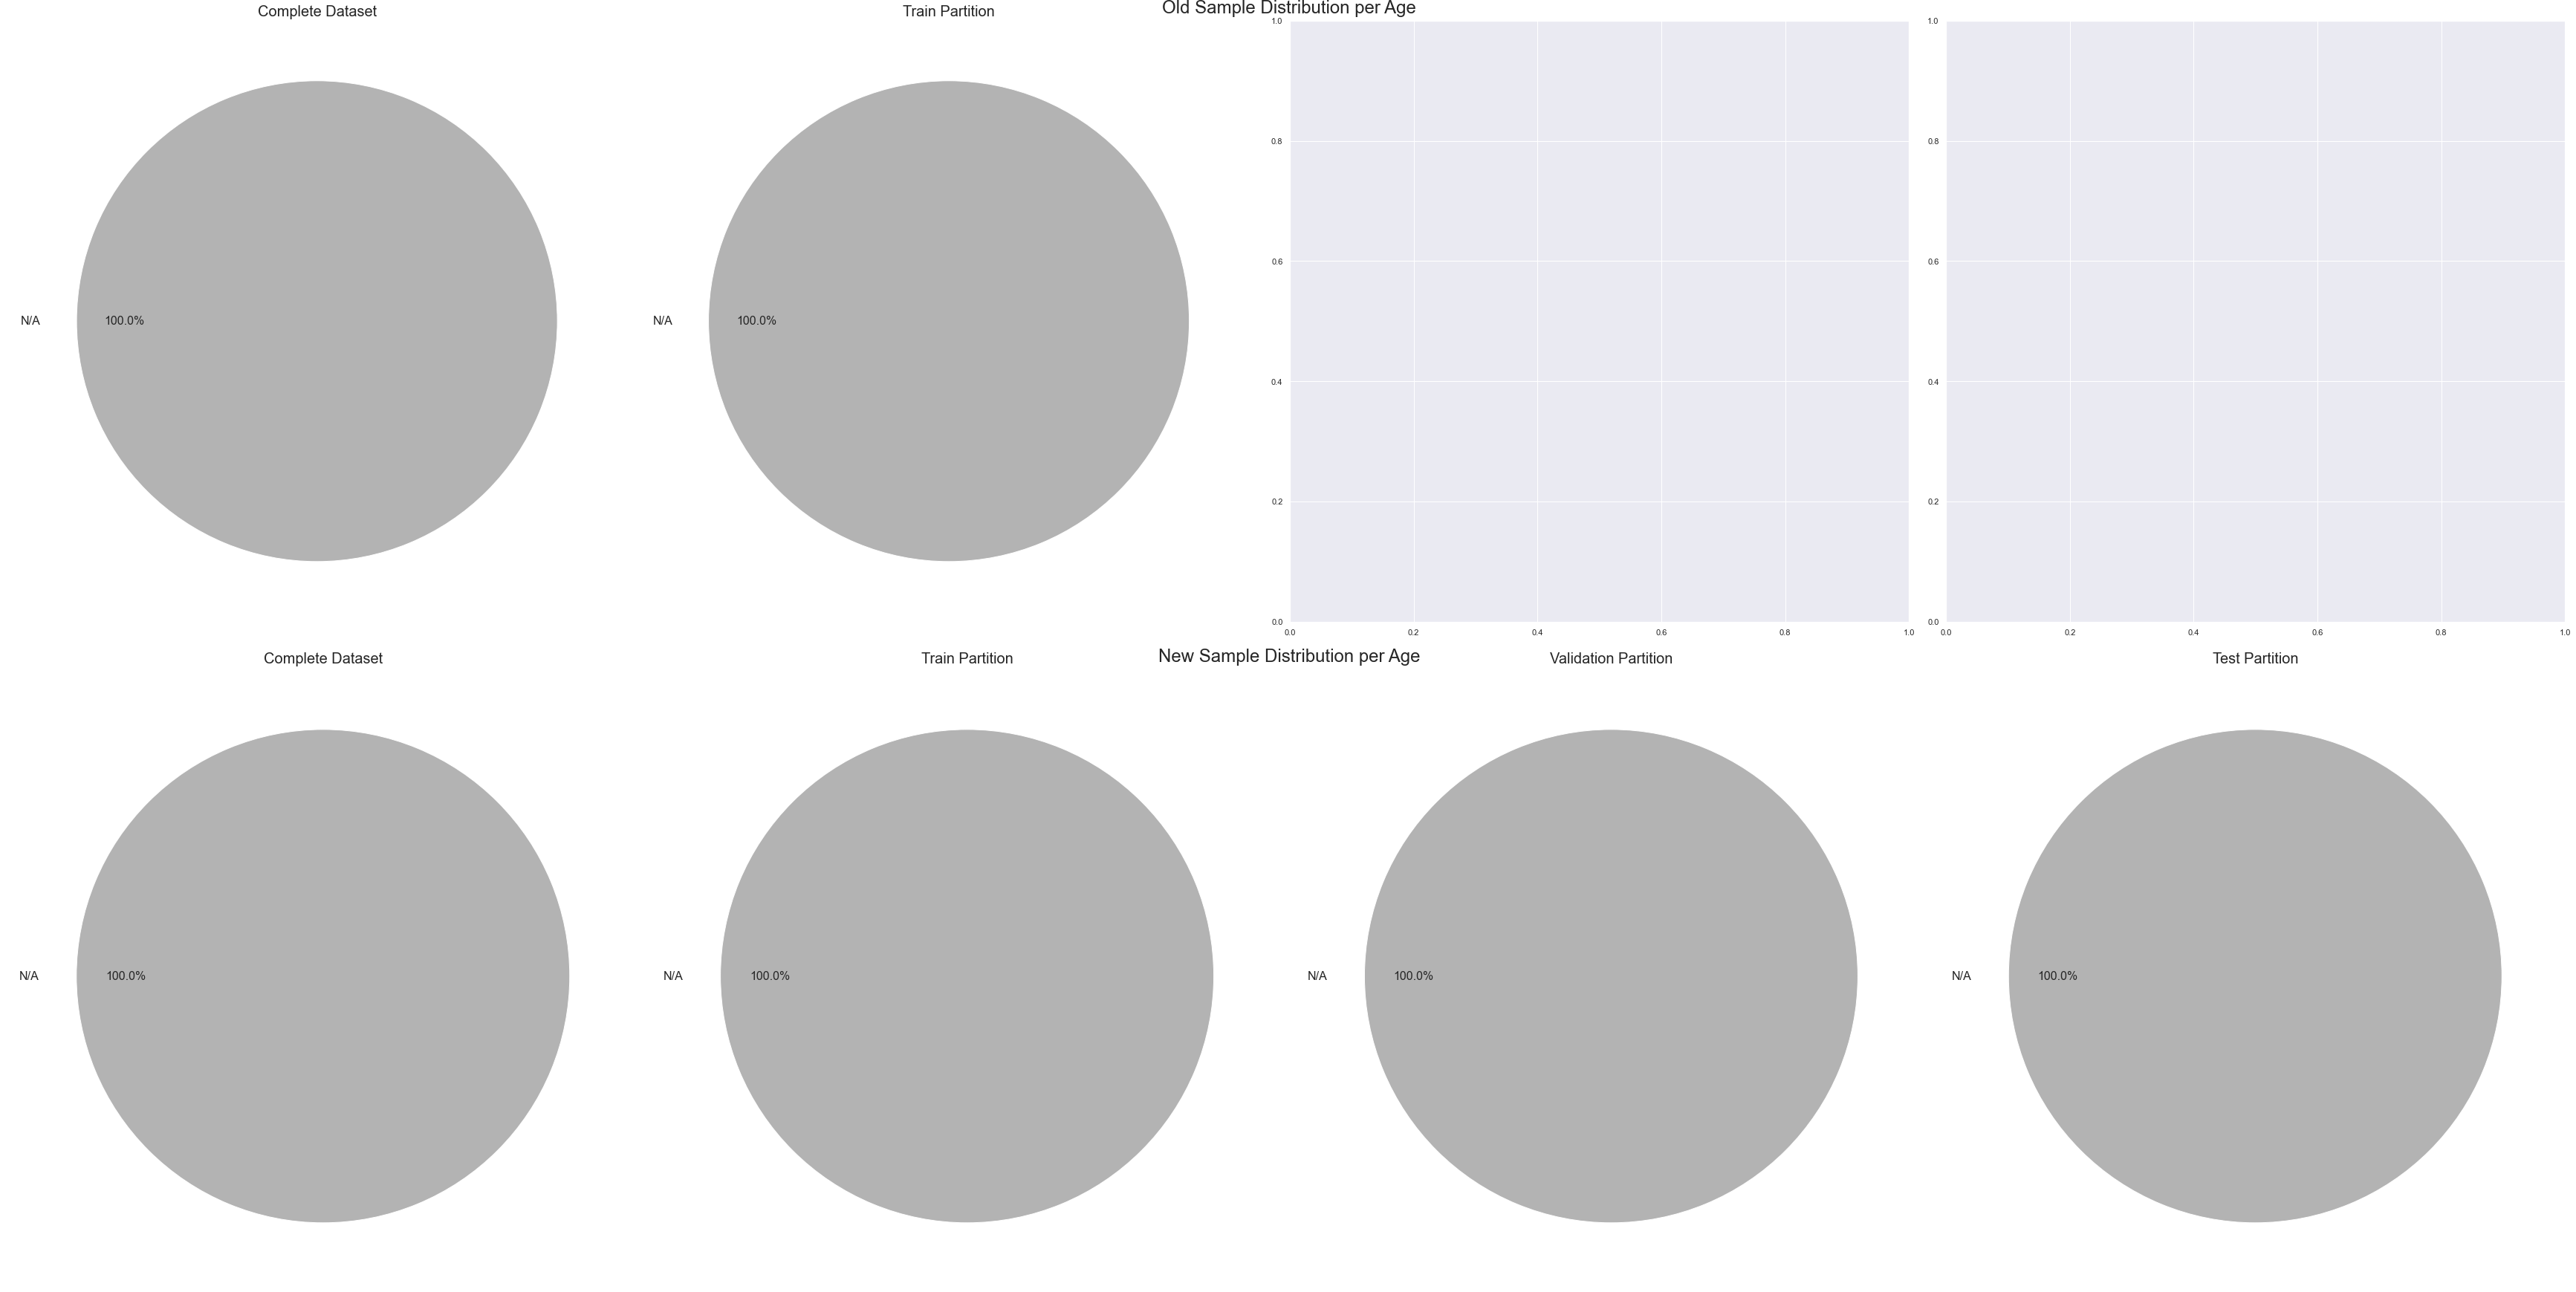

In [24]:
plot.column_as_pies( samples_df, new_samples_df, "age", dataset_name, figsize = (48, 24), resplit = True)

In [25]:
plot.column_as_table( samples_df, new_samples_df, "age", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
N/A,14461,14461,0,0
Known Ages,0,0,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
N/A,14461,8691,2880,2890
SUM,14461,8691,2880,2890


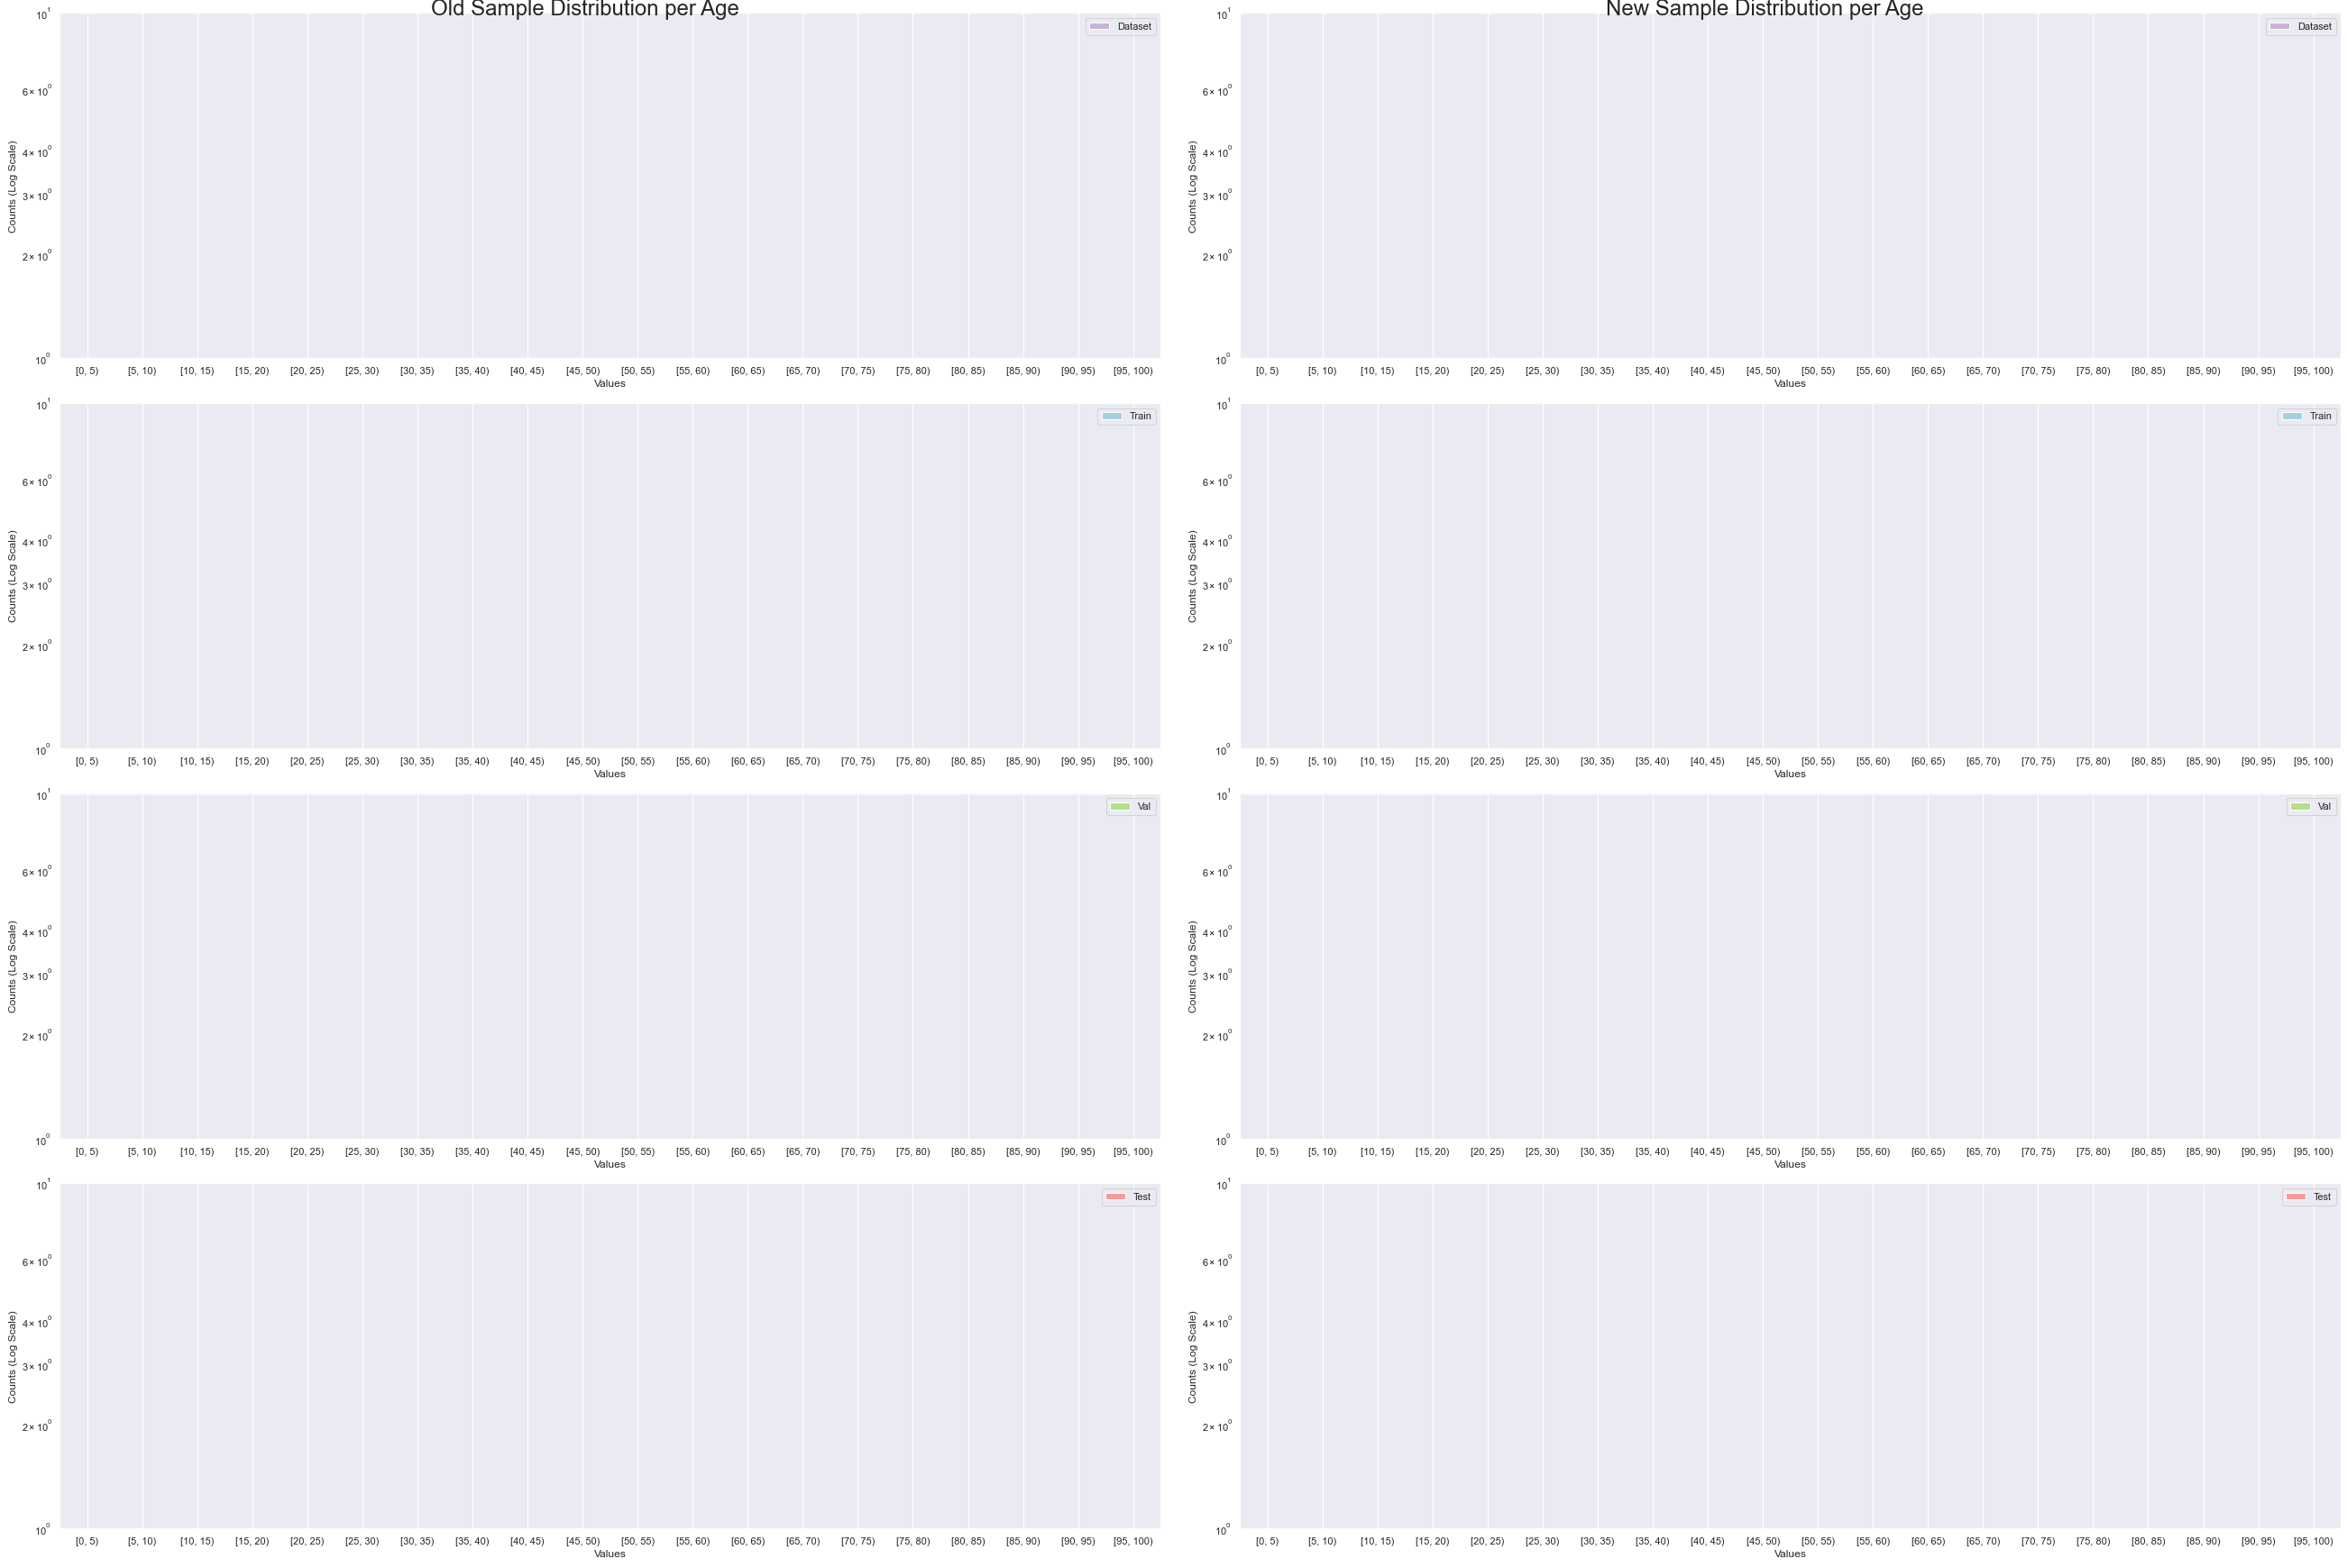

In [26]:
plot.column_as_histograms( samples_df, new_samples_df, "age", dataset_name, figsize = (36, 24), resplit = True)

In [27]:
plot.column_as_table( samples_df, new_samples_df, "age", dataset_name, bin_flag = True, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
"[0, 5)",0,0,0,0
"[5, 10)",0,0,0,0
"[10, 15)",0,0,0,0
"[15, 20)",0,0,0,0
"[20, 25)",0,0,0,0
"[25, 30)",0,0,0,0
"[30, 35)",0,0,0,0
"[35, 40)",0,0,0,0
"[40, 45)",0,0,0,0


## Sex

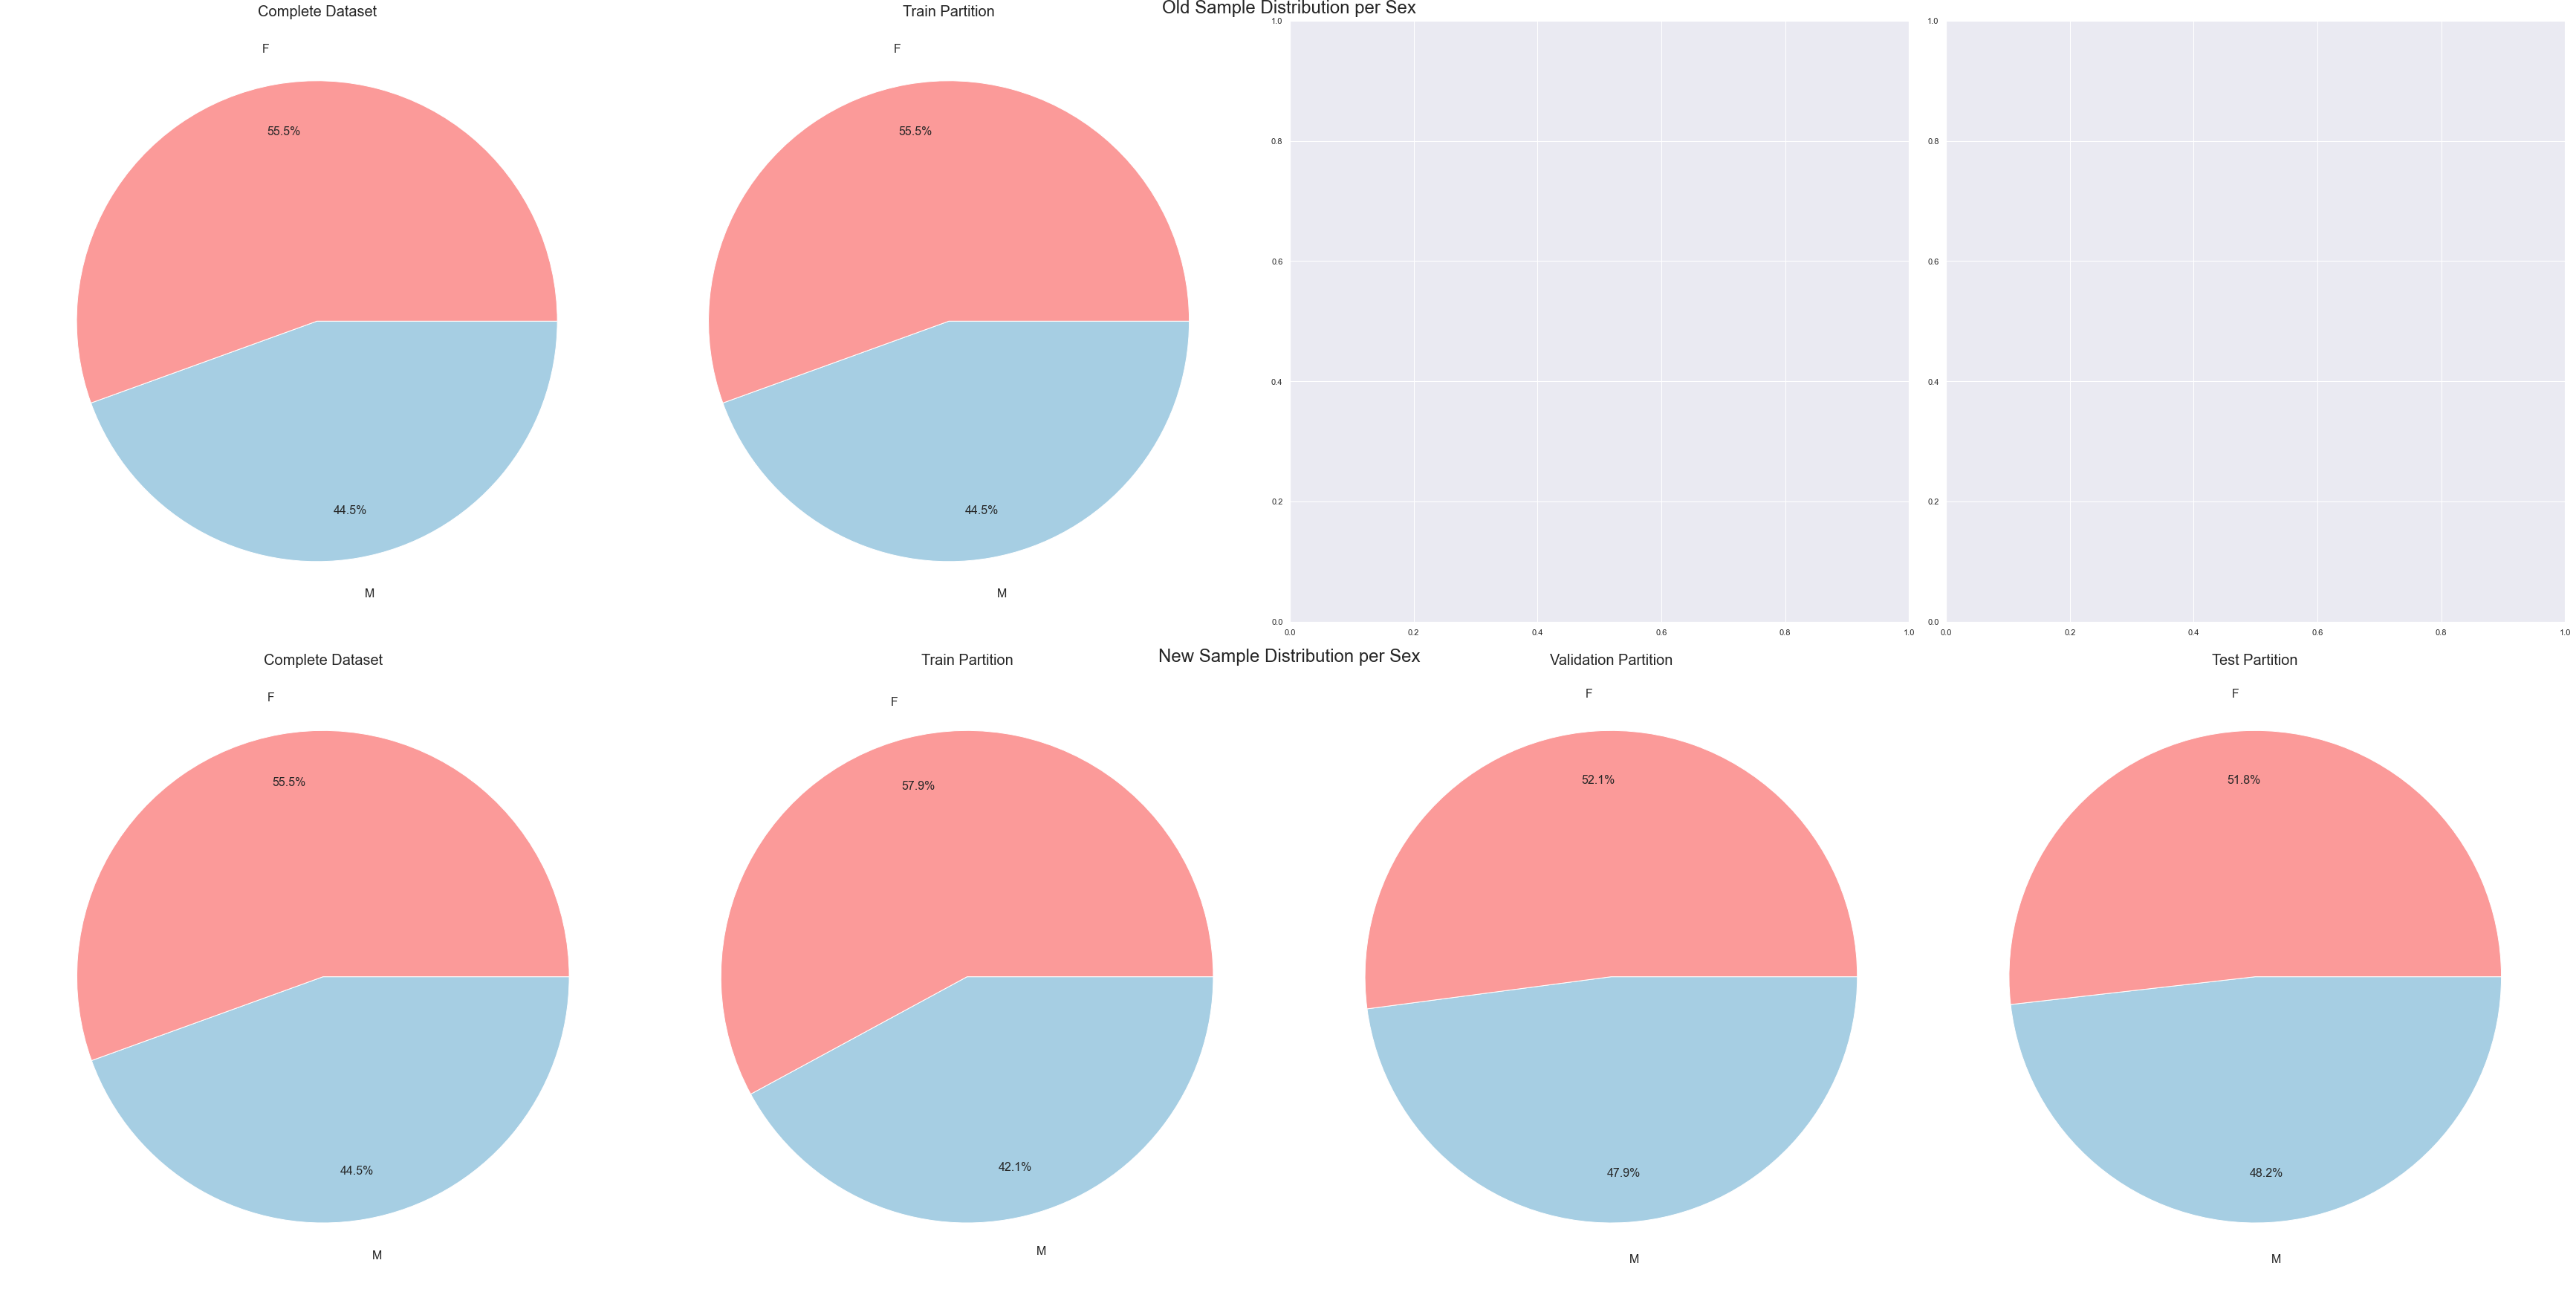

In [28]:
plot.column_as_pies( samples_df, new_samples_df, "sex", dataset_name, figsize = (48, 24), resplit = True )

In [29]:
plot.column_as_table( samples_df, new_samples_df, "sex", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
M,6431,6431,0,0
N/A,0,0,0,0
F,8030,8030,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
F,8030,5033,1500,1497
M,6431,3658,1380,1393
SUM,14461,8691,2880,2890


## Country

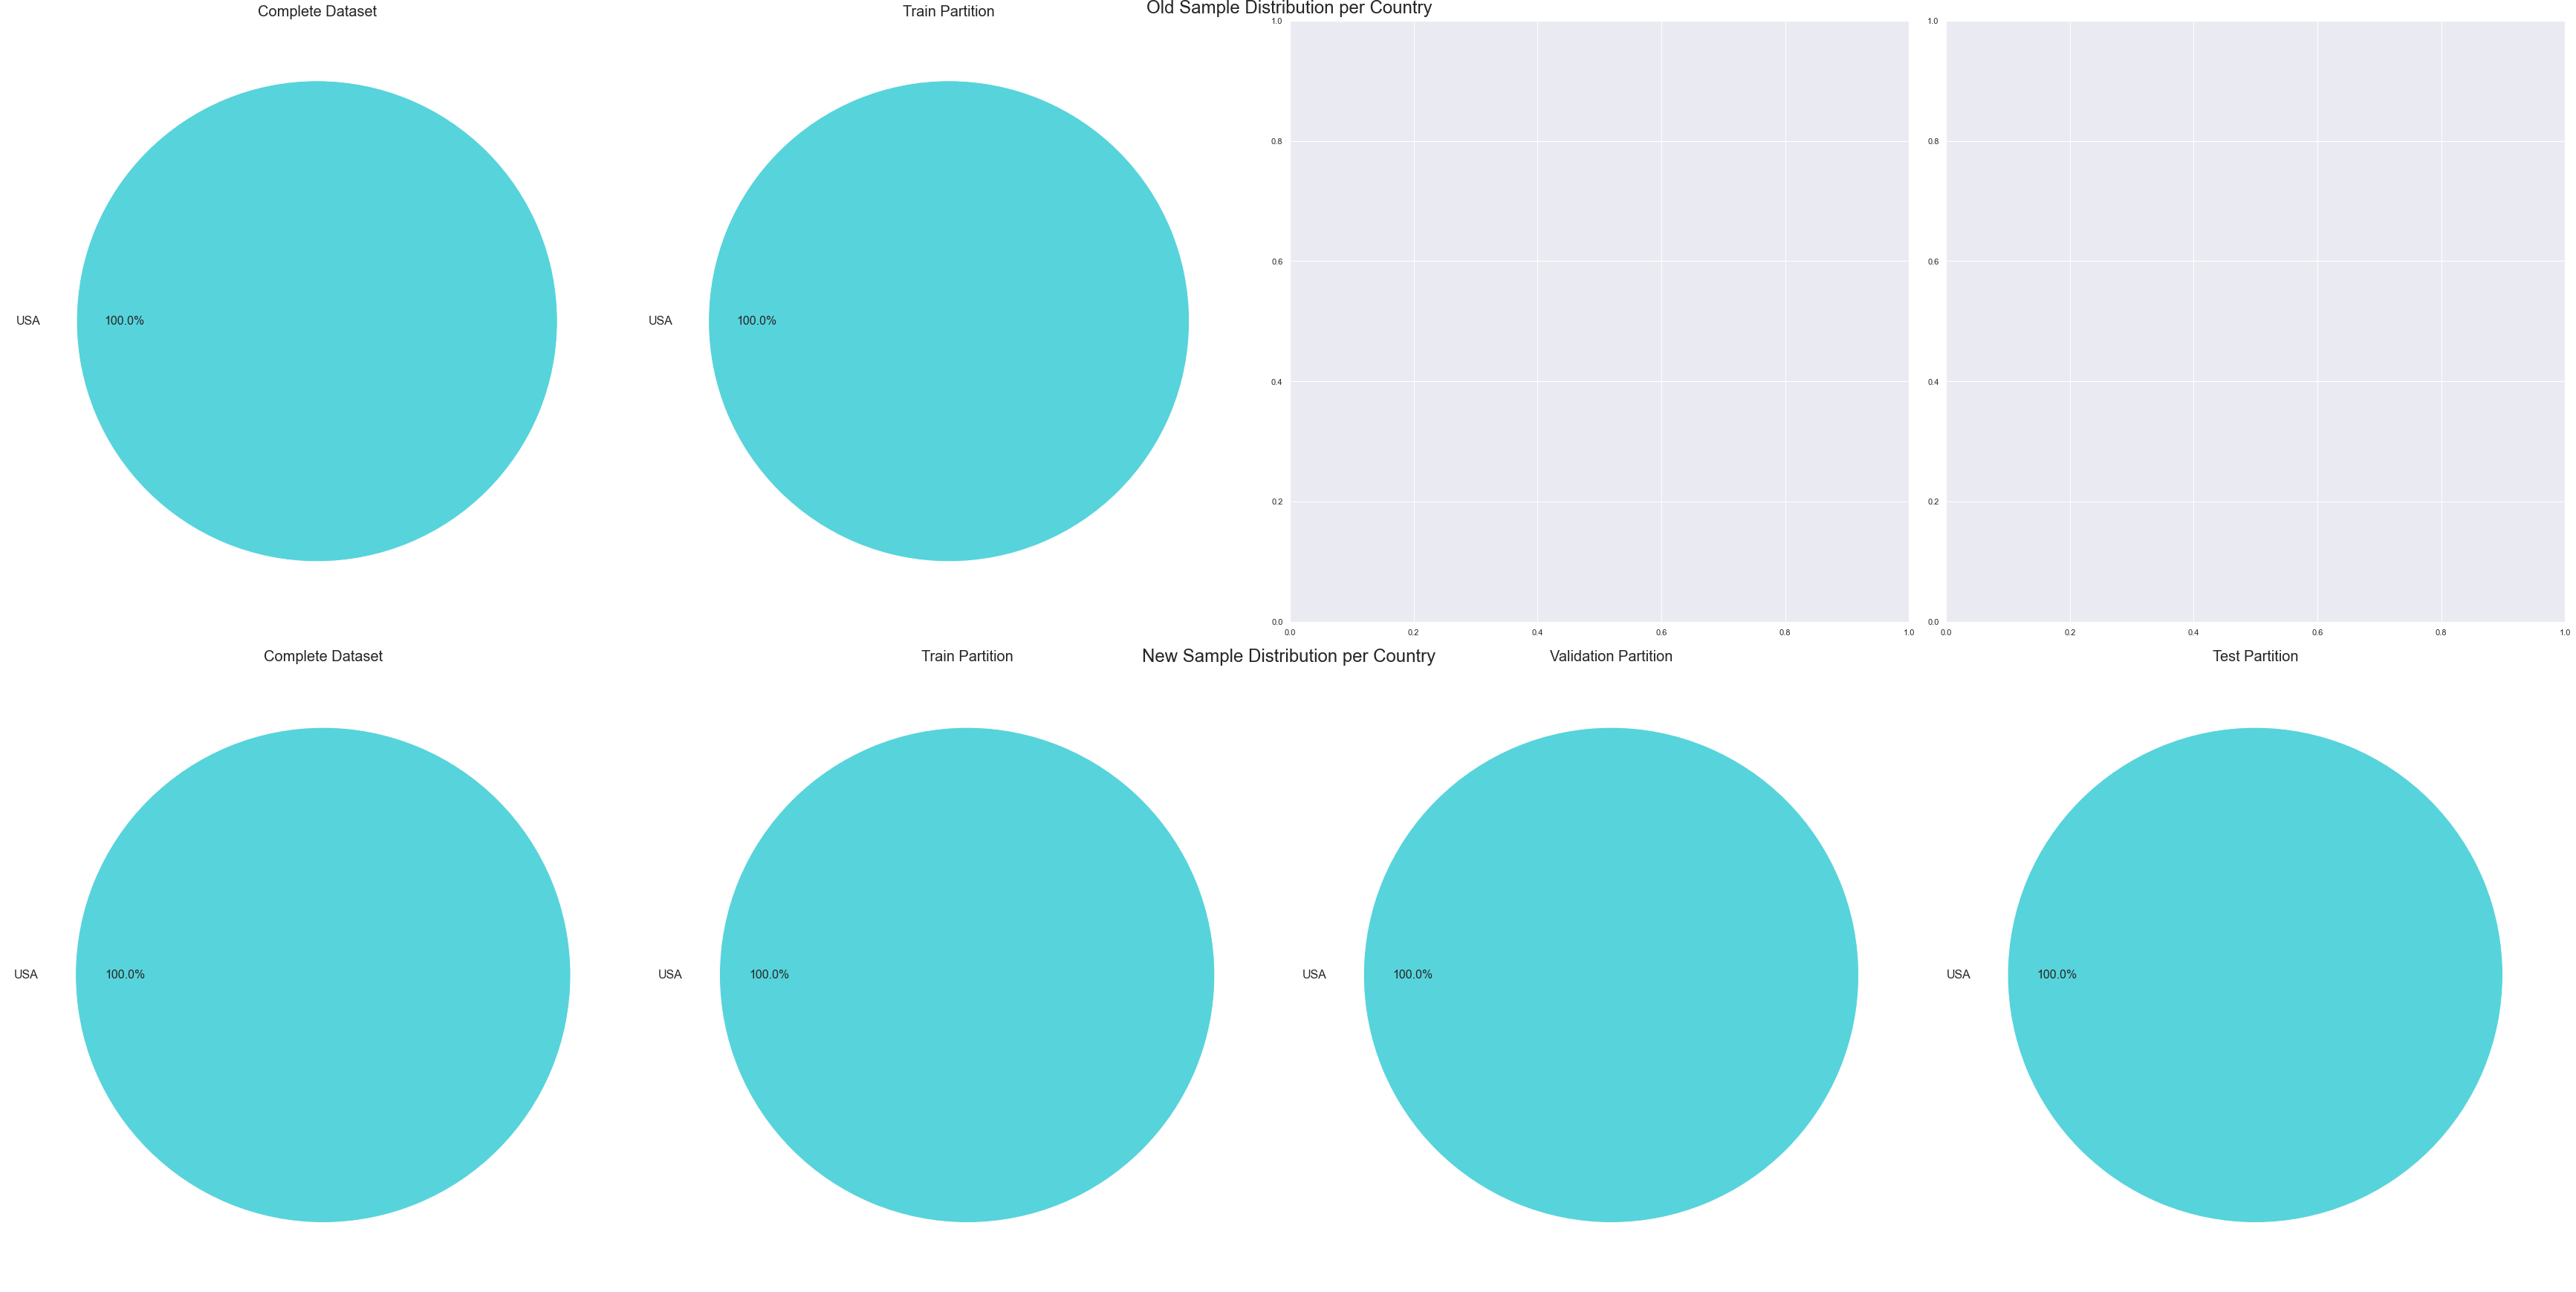

In [30]:
plot.column_as_pies( samples_df, new_samples_df, "country", dataset_name, figsize = (48, 24), resplit = True )

In [31]:
plot.column_as_table( samples_df, new_samples_df, "country", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
France,0,0,0,0
China,0,0,0,0
Iran,0,0,0,0
USA,14461,14461,0,0
N/A,0,0,0,0
Australia,0,0,0,0
Italy,0,0,0,0
Algeria,0,0,0,0
Belgium,0,0,0,0


## Partition

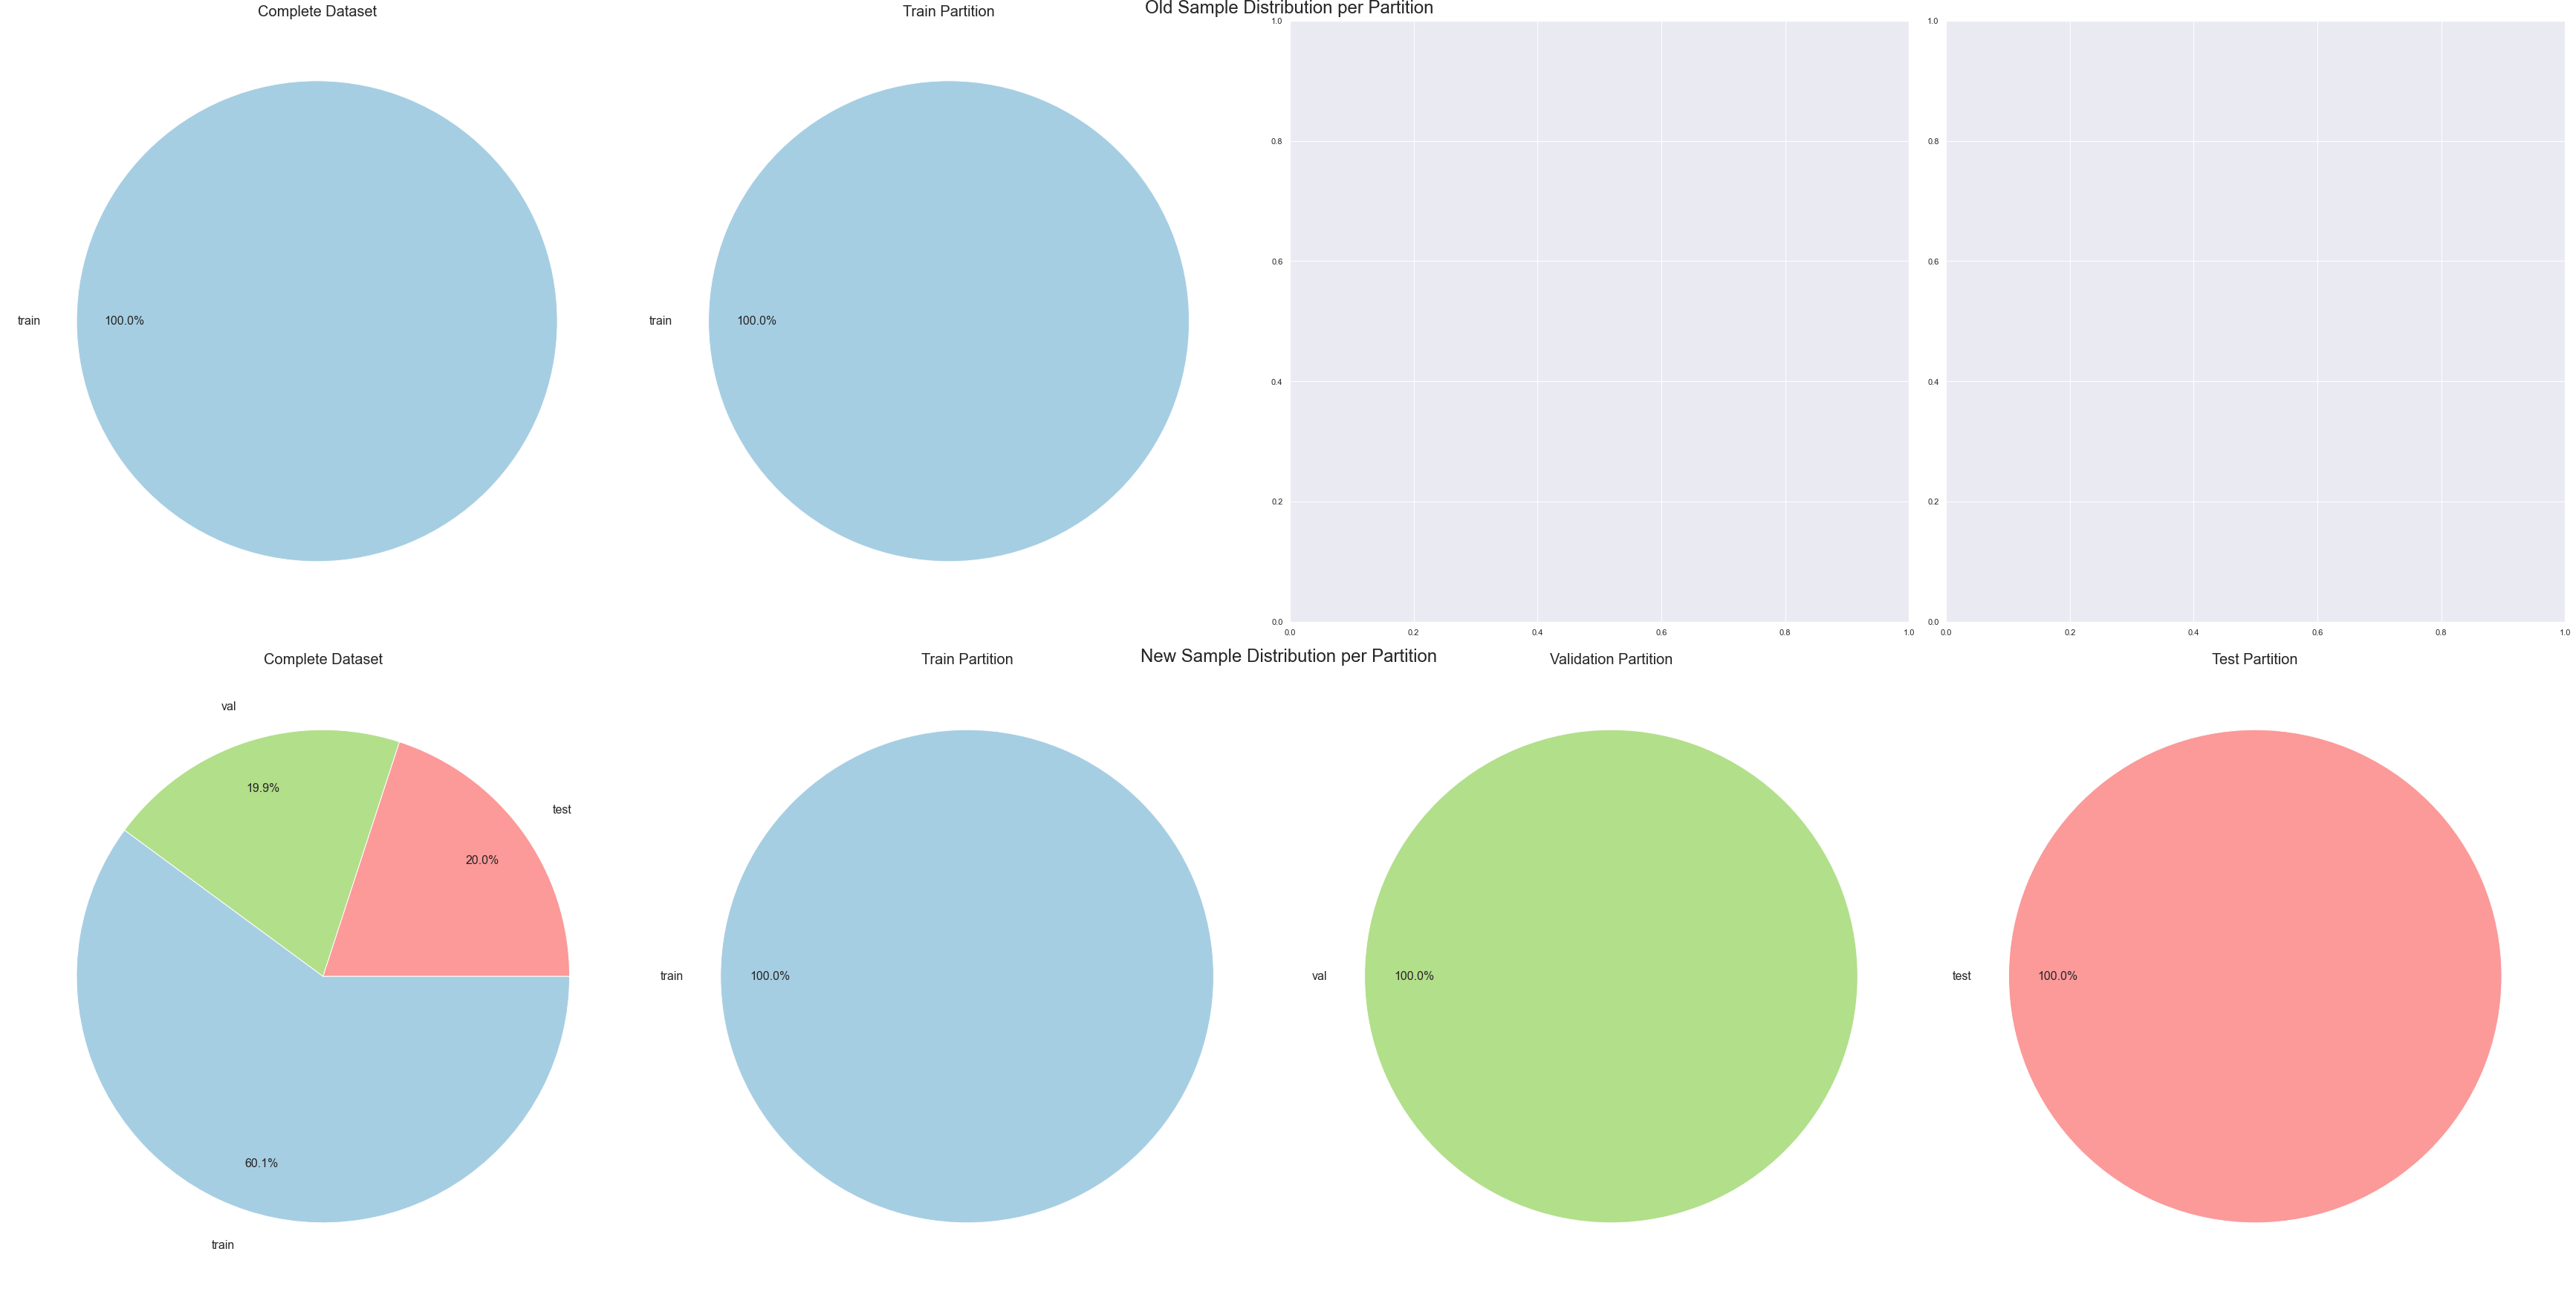

In [32]:
plot.column_as_pies( samples_df, new_samples_df, "partition", dataset_name, figsize = (48, 24), resplit = True )

In [33]:
plot.column_as_table( samples_df, new_samples_df, "partition", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
train,14461,14461,0,0
test,0,0,0,0
val,0,0,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
train,8691,8691,0,0
test,2890,0,0,2890
val,2880,0,2880,0


## Slice Selection

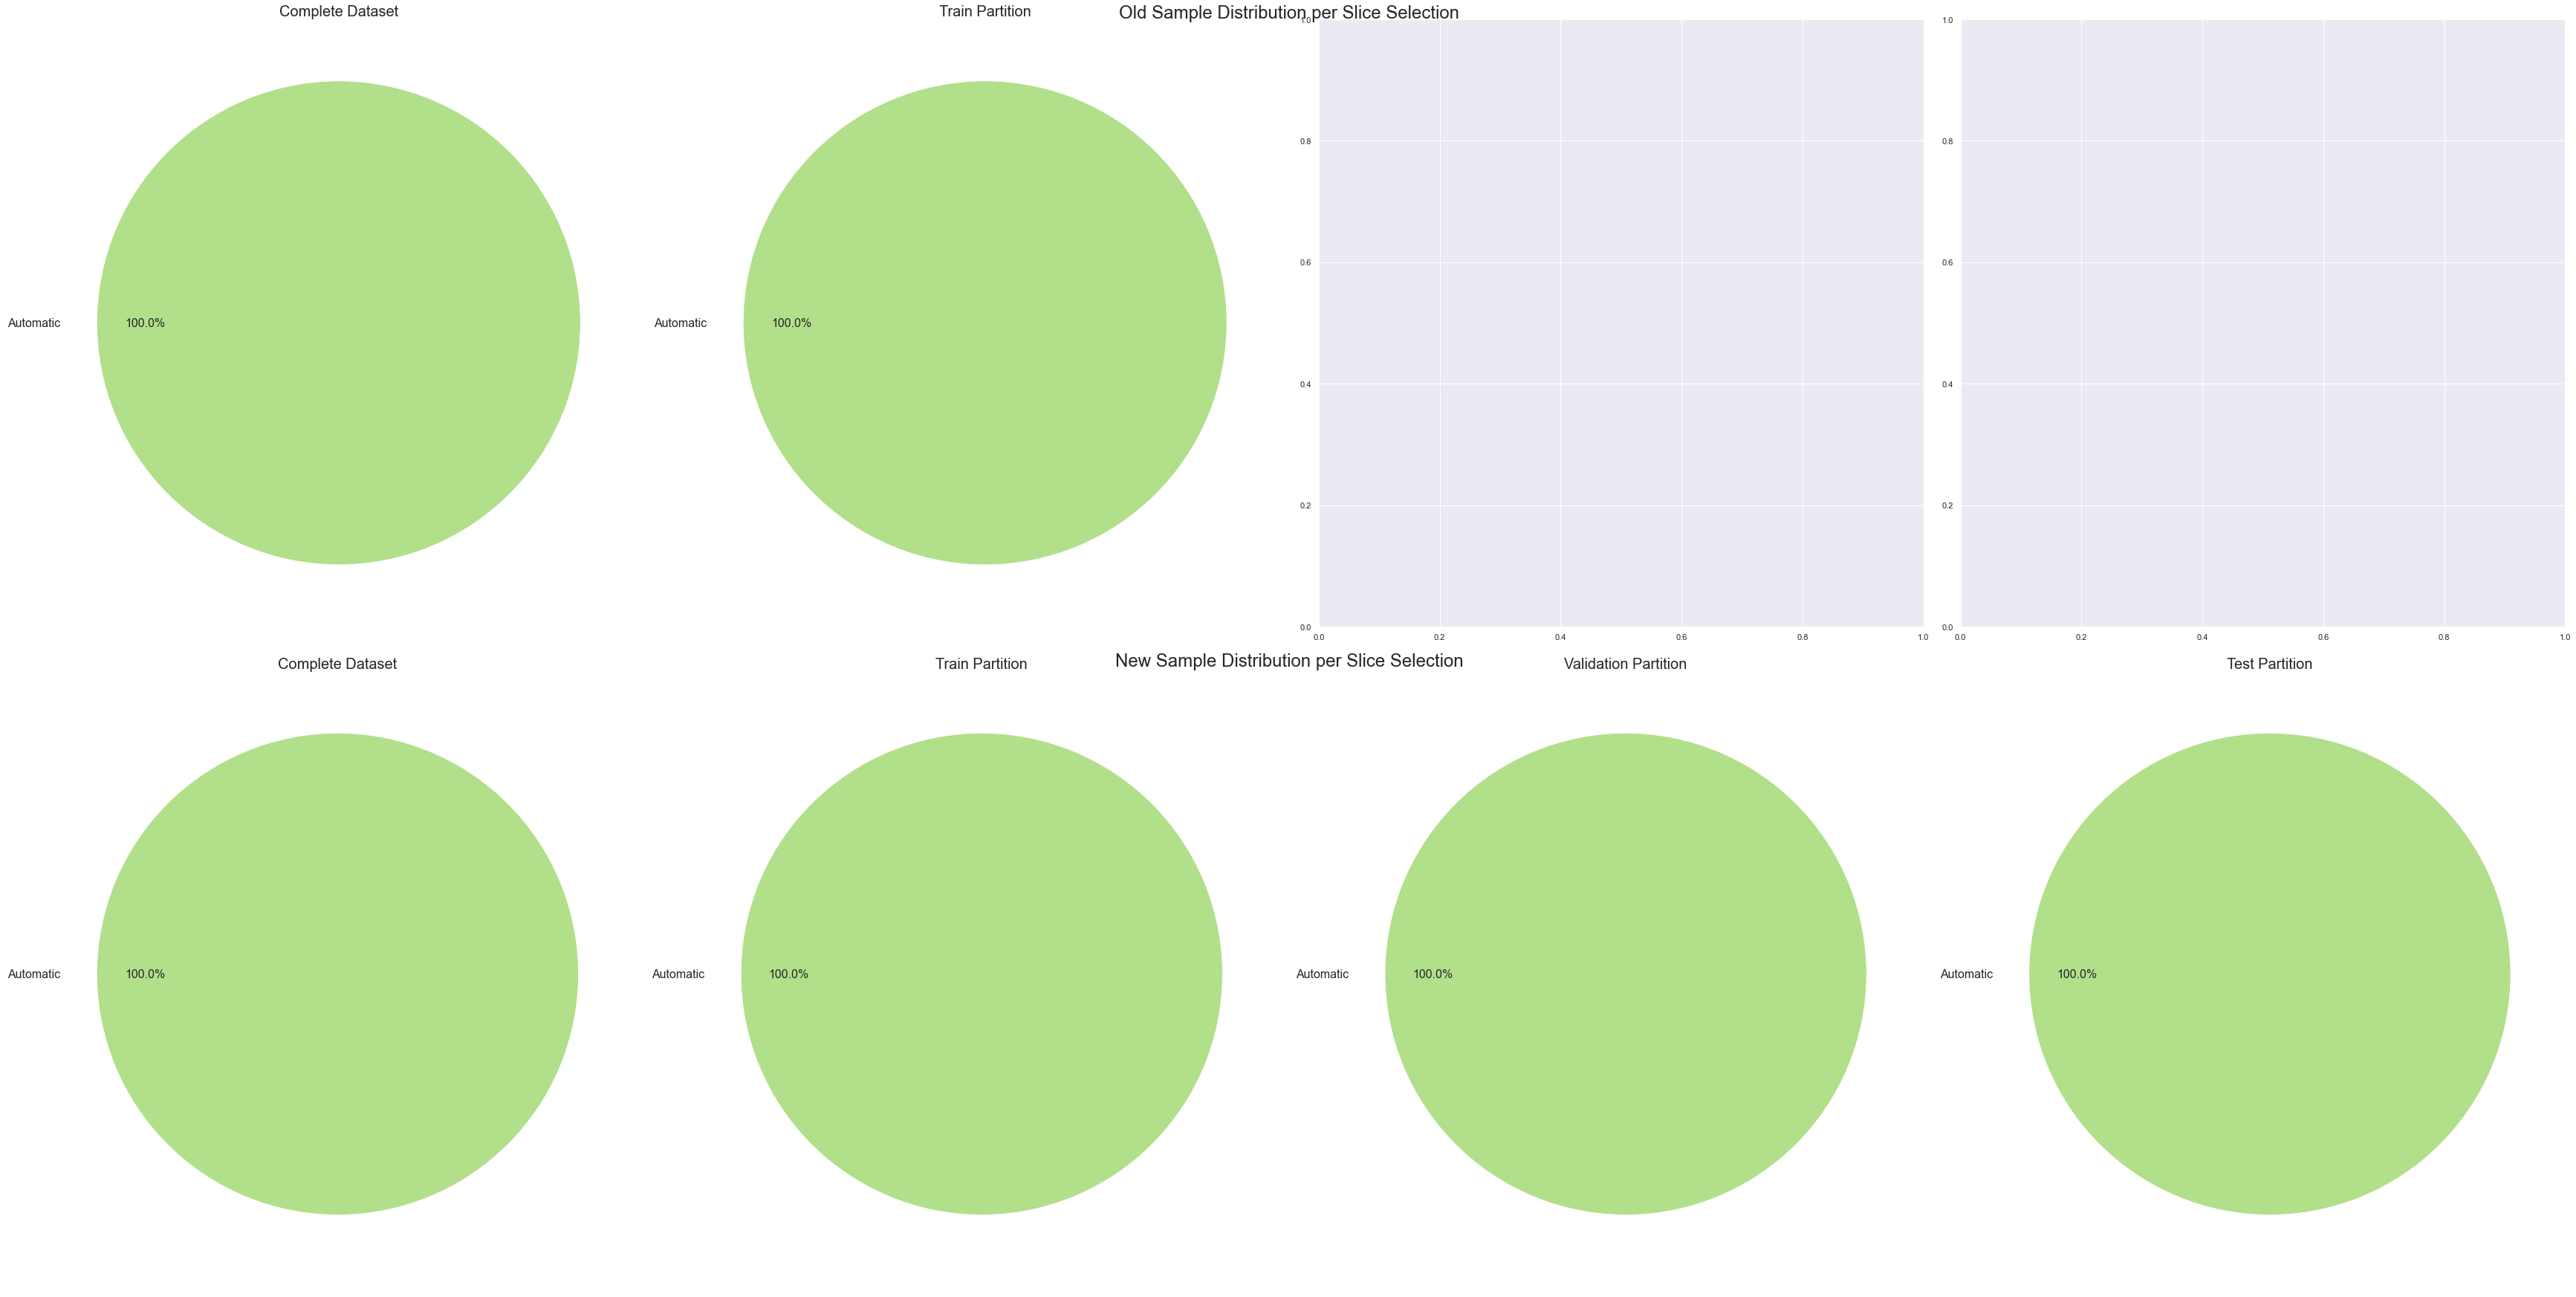

In [34]:
plot.column_as_pies( samples_df, new_samples_df, "slice_selection", dataset_name, figsize = (48, 24), resplit = True )

In [35]:
plot.column_as_table( samples_df, new_samples_df, "slice_selection", dataset_name, bin_flag = False, resplit = True )

,Dataset,Train,Val,Test
Values,,,,
Automatic,14461,14461,0,0
Expert,0,0,0,0
N/A,0,0,0,0
Non-expert,0,0,0,0
SUM,14461,14461,0,0
,Dataset,Train,Val,Test
Values,,,,
Automatic,14461,8691,2880,2890
SUM,14461,8691,2880,2890


# Registering Changes

In [36]:
# Path to save new metadata csv
csv_export_path = os.path.join( data_dir, "new_split_metadata.csv" )

updated_df = split.update_metadata_csv( csv_export_path, new_samples_df, dataset_name, save_bool = True )
print( len(updated_df), len(new_samples_df) )
updated_df.head()

425024 14461


,filename,patient_id,source,class,country,sex,age,partition,slice_selection,x_min,y_min,x_max,y_max,verified_finding,view,modality
0,NCP_96_1328_0032.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,9,94,512,405,Yes,Axial,CT
1,NCP_96_1328_0035.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,106,512,405,Yes,Axial,CT
2,NCP_96_1328_0036.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,10,105,512,406,Yes,Axial,CT
3,NCP_96_1328_0037.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,104,512,406,Yes,Axial,CT
4,NCP_96_1328_0038.png,NCP_96,CNCB,COVID-19,China,M,74.0,train,Expert,11,103,512,406,Yes,Axial,CT
